# **Decifrare le Reti Neurali e la Back Propagation**
### **Esplorando la Teoria e la Pratica attraverso lo sviluppo di Micrograd**

Dennis Remigio, Maggio 2024

**Obiettivi**: Esplorare il funzionamento delle reti neurali e il meccanismo di back propagation, ricreando la libreria `micrograd` passo dopo passo.

**Precompetenze**: basi di Python, fondamenti di calcolo differenziale

&nbsp;

---

Adattamento ed approfondimento della lezione di **Andrej Karpathy, PhD**: *The spelled-out intro to neural networks and backpropagation: building micrograd*, disponibile [qui](https://www.youtube.com/watch?v=VMj-3S1tku0&list=LL&index=1).

---

&nbsp;

Per eseguire questo notebook, supponiamo con VSCode, occorre:
* Installare un interprete Python
* Scaricare VSCode (da [qui](https://code.visualstudio.com/download)) e installarlo
* Eseguire VSCode e attivare le estensioni per Python e Jupyter
* Ancora in VSCode:
    * Creare una cartella di lavoro e renderla la cartella corrente
    * Copiare nella cartella questo notebook e aprirlo
    * Creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
    * Installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install autograd numpy matplotlib graphviz torch micrograd`
* Scaricare Graphviz (da [qui](https://graphviz.org/download/)) e installarlo
    * Impostare graphviz come variabile di ambiente in Path

## **Indice**

[**Introduzione**](#s0)  
[**1 - Fondamenti Matematici: Il Coefficiente Angolare**](#s1)  
[**2 - Definizione della classe `Value` per il Forward Pass**](#s2)  
[**3 - Definizione della classe `Value` per il Backward Pass**](#s3)  
[**4 - Svolgimento della Back Propagation**](#s4)  
[**5 - Addestramento**](#s5)  
[**6 - Introduzione alle Reti Neurali**](#s6)  
[**7 - Automatizzazione della Back Propagation**](#s7)  
[**8 - Implementazioni possibili**](#s8)  
[**9 - Addestramento nella pratica: `PyTorch`**](#s9)  
[**Conclusioni**](#s10)  

<a name="s1"></a>
## **Introduzione**

Questo articolo si propone di esplorare in modo dettagliato la progettazione della libreria `micrograd`, allo scopo di illustrare il funzionamento delle reti neurali e dei loro processi di addestramento. Inizieremo esaminando operazioni matematiche elementari e progressivamente introdurremo concetti più complessi e tecnicamente avanzati.

L'obiettivo fondamentale delle reti neurali è di prevedere risultati accurati partendo da dati di input. Queste previsioni migliorano attraverso un processo di addestramento durante il quale la rete apprende a modellare la relazione tra gli input e i risultati desiderati. Questo articolo dimostra, tramite `micrograd`, come una rete può apprendere questa capacità. Esploreremo quindi il concetto di backpropagation, una tecnica fondamentale per l'aggiustamento dei pesi della rete in base agli errori di previsione, tramite il calcolo dei gradienti.

Per illustrare praticamente questi concetti, consideriamo un semplice esempio di codice che utilizza `micrograd`. Nel codice seguente, definiamo due variabili, `a` e `b`, come oggetti `Value`, permettendoci di registrare l'intero storico delle operazioni matematiche effettuate su di esse, per arrivare a un risultato finale `g`. Inoltre, consente di calcolare i gradienti di `a` e `b`.

In [ ]:
import autograd numpy matplotlib graphviz torch micrograd

In [ ]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)

# Operazioni per calcolare 'g'
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f

print(f'Valore di g: {g.data:.4f}')

g.backward()
print(f'Gradiente di a: {a.grad:.4f}')
print(f'Gradiente di b: {b.grad:.4f}')

Valore di g: 24.7041
Gradiente di a: 138.8338
Gradiente di b: 645.5773


Questo esempio illustra come le variabili `a` e `b` influenzino direttamente il valore di `g`. Supponendo che l'obiettivo sia ottenere un valore di `g` più elevato, i gradienti ci forniscono una guida su come modificare `a` e `b` per raggiungere tale risultato. Dato che entrambi i gradienti sono positivi, incrementare leggermente `a` e/o `b` porterà a un aumento del valore di `g`, proporzionale all'entità dei gradienti.

Questo principio ha una rilevanza diretta e immediata nel contesto delle reti neurali. Analogamente al caso di `g` nel nostro esempio, nelle reti neurali il valore di interesse potrebbe essere l'errore di previsione. Conoscendo i gradienti, possiamo identificare con precisione come modificare i parametri della rete per minimizzare questo errore, migliorando così l'accuratezza delle previsioni. Questo processo di ottimizzazione è fondamentale per l'efficacia del modello di apprendimento automatico, permettendo di affinare continuamente le prestazioni attraverso aggiustamenti iterativi.

Iniziamo ora un percorso progressivo che ci porterà dalle fondamenta della programmazione alla creazione di una funzione autograd essenziale, denominata Value, che abbiamo appena esplorato nell'esempio precedente. Questa funzione rappresenta il cuore della libreria micrograd, e la comprensione del suo funzionamento è cruciale per applicarla efficacemente nell'addestramento di reti neurali.

Per cominciare, occorre importare le librerie essenziali che ci permetteranno di costruire e manipolare le strutture necessarie.

In [ ]:
# Iniziamo importando le librerie
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a name="s2"></a>
## **1 - Fondamenti Matematici: Il Coefficiente Angolare**

In questo capitolo esploreremo il concetto di coefficiente angolare di una funzione. Questo concetto è fondamentale per comprendere come le funzioni cambiano in risposta alle variazioni delle variabili su cui operano. Un'introduzione approfondita al coefficiente angolare ci permetterà di prepararci alla comprensione e all'uso dei gradienti nelle reti neurali, un argomento che esploreremo in dettaglio nei capitoli successivi.

Per iniziare, definiamo una semplice funzione matematica `f(x)` che descrive una parabola:

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

Testiamo questa funzione con un valore di esempio, `x = 3.0`

In [ ]:
f(3.0)

20.0

Per visualizzare meglio il comportamento della funzione, tracciamo il suo grafico:

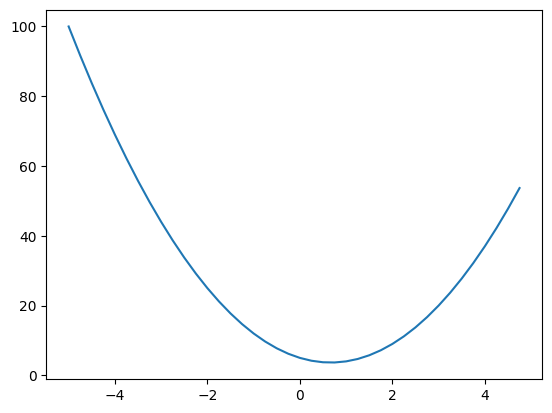

In [ ]:
xs = np.arange(-5, 5, 0.25)  # Generiamo valori di x da -5 a 5 a intervalli di 0.25
ys = f(xs)                   # Calcoliamo y per ogni x
plt.plot(xs, ys)             # Rappresentiamo il grafico
plt.show()

Calcoliamo ora la derivata della funzione secondo la definizione di derivata, applicandola ad un punto arbitrario (lo scopo è di mostrare il coefficiente angolare in un dato punto, ovvero la pendenza di una retta tengente alla curva in quel punto, ovviamente modificando la `x` si può individuare la variazione del coefficiente angolare lungo la curva)

Infine, calcoliamo la derivata della funzione in un punto, per osservare il coefficiente angolare in quel punto:

In [ ]:
# Definizione dell'incremento
h = 0.000001

# Valore di 'x'
x = 2/3

# Calcolo della derivata
derivative = (f(x + h) - f(x)) / h

print(f'Derivata della funzione al punto x = {round(x, 4)}: {round(derivative, 4)}')

Derivata della funzione al punto x = 0.6667: 0.0


Per `x = 2/3`, il coeffiente angolare è circa `0`, indicando che l'inclinazione della curva è approssimativamente orizzontale, ovvero che, aumentando in maniera incrementale il valore di `x`, la funzione non avrebbe un aumento significativo.

### **Comprensione del Coefficiente Angolare con un Esempio Pratico**

Dopo aver compreso il calcolo del coefficiente angolare tramite derivata, vediamo ora come si applica questo concetto in un contesto pratico. Consideriamo le variabili `a`, `b` e `c`, e osserviamo come influenzano il risultato di un'operazione semplice che restituisce il valore `d`.

In [ ]:
# Definizione iniziale delle variabili
a = 2.0
b = -3.0
c = 10.0

# Calcolo di 'd'
d = a * b + c

print('d =', d)

d = 4.0


#### **a) Variazione di `a` e impatto sul coefficiente angolare**

Incrementiamo `a` di un piccolo valore `h` e osserviamo l'effetto sul risultato finale `d`, calcolando il coefficiente angolare associato:

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h # aumento incrementale
d2 = a*b + c

print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2 - d1)/h)

d1 = 4.0
d2 = 3.999699999999999
slope = -3.000000000010772


Questo esperimento dimostra che, dato che `b` è negativo, l'incremento di `a` riduce `d`. La derivata, quindi il coefficiente angolare, risulta negativa.

#### **b) Effetto dell'incremento di `b`**

Analogamente, incrementiamo `b` per vedere come varia `d`:

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2 - d1) / h)

d1 = 4.0
d2 = 4.0002
slope = 2.0000000000042206


L'aumento di `b` fa aumentare `d`, e quindi il coefficiente angolare è positivo, mostrando che `d` è direttamente proporzionale a `b`.

#### **c) Variazione di `c` e il suo impatto**

Infine, incrementiamo `c`:

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2 - d1)/h)

d1 = 4.0
d2 = 4.0001
slope = 0.9999999999976694


L'incremento di `c` aumenta direttamente `d` di una quantità uguale a `h`, riflettendo un coefficiente angolare di `1.0`. Ciò indica che ogni incremento unitario di `c` si traduce in un aumento unitario di `d`.

<a name="s2"></a>
## **2 - Definizione della classe `Value` per il Forward Pass**

Ora che abbiamo compreso il significato di coefficiente angolare tramite esempi molto semplici, possiamo iniziare a definire la classe `Value`.

Introduzione ai metodi speciali

In Python, le classi possono implementare determinate operazioni attraverso metodi speciali. Questi metodi sono riconoscibili dai due underscore (`__`) che precedono e seguono il nome del metodo. Sono utili per definire comportamenti personalizzati per operazioni standard come, ad esempio, l'inizializzazione, la rappresentazione, e l'addizione di oggetti.

Iniziamo a definire la classe `Value` introducendo i seguenti metodi speciali:

- `__init__`: Questo metodo è chiamato automaticamente quando un nuovo oggetto viene creato. Serve per inizializzare gli attributi dell'oggetto.
- `__repr__`: Questo metodo è utilizzato per per formattare il risultato in maniera chiara e comprensibile.

In [ ]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

a = Value(2.0)
a

Value(data=2.0)

Una volta definita la classe `Value` con i metodi di base, possiamo estenderla per permettere operazioni tra i suoi oggetti.
Se infatti tentassimo di sommare due oggetti di classe `Value` il sistema restituirebbe un errore, in quanto Python non conosce alcun metodo standard per gestire l'addizione tra oggetti di classe `Value`.

Per abilitare questa operazione, implementiamo un altro metodo speciale:
- `__add__`: Questo metodo sovrascrive l'operatore `+`, permettendo di sommare due oggetti di tipo `Value`.

In [ ]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
a + b # essendo 'a' e 'b' oggetti di classe Value, python leggerà a.__add__(b), in cui "a" rappresenterà "self", e "b" rappresenterà "other"

Value(data=-1.0)

Implementiamo ora un metodo speciale per gestire anche le moltiplicazioni, strutturato in maniera molto simile ad `__add__`, per poter gestire l'operazione `a*b + c`

In [ ]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a*b + c # in questo modo, python leggerà (a.__mul__(b)).__add__(c)


Value(data=4.0)

Vogliamo ora introdurre la possibilità di registrare lo storico delle operazioni effettuate sugli oggetti della classe `Value`.

Per iniziare, modifichiamo il metodo `__init__` per accettare un parametro opzionale chiamato `_children`.
Questo parametro sarà una tupla che contiene i "genitori" dell'oggetto `Value`, ovvero gli oggetti da cui è derivato.

Utilizzeremo `_children` per inizializzare una variabile chiamata `_prev`, che sarà inizialmente un set vuoto.

Aggiungeremo logica nei metodi `__add__` e `__mul__` per registrare le relazioni tra oggetti. Ogni volta che creiamo un nuovo oggetto `Value` tramite queste operazioni, passeremo gli oggetti coinvolti (i "genitori") al nuovo oggetto.

In [ ]:
class Value:

    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # Passiamo self e other come genitori del nuovo oggetto Value
        out = Value(self.data + other.data, (self, other))
        return out

    def __mul__(self, other):
        # Passiamo self e other come genitori del nuovo oggetto Value
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

Possiamo quindi richiamare i diretti genitori di `d`, ovvero il risultato di `a*b`, e `c`

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

Possiamo quindi sapere chi sono i genitori, ma non abbiamo la possibilità di sapere quali operazioni hanno portato alla creazione del figlio.

Aggiungiamo quindi un ulteriore parametro al metodo `__init__`, ovvero `_op`.

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # Aggiungiamo l'informazione relativa all'operazione, in questo caso "+"
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        # Aggiungiamo l'informazione relativa all'operazione, in questo caso "*"
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(data=4.0)

Possiamo ora sapere chi sono i genitori ed anche quali sono state le operazioni (in questo caso, la somma tra `a*b` e `c`):

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

Ora, per vedere meglio i risultati, aggiorniamo il codice aggiungendo delle etichette a ciascun elemento (aggiungento il parametro `label` al metodo `__init__`).

Aggiungiamo l'informazione relativa all'etichetta in ogni operazione, per avere tutte le etichette di ciascuna fase del processo.

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
d

Value(data=4.0)

Per comprendere meglio l'intero processo rappresenteremo tutte le operazioni graficamente.

Per farlo, implementeremo un codice (che non esploreremo nel dettaglio in questa trattazione) che sfrutta la libreria `graphviz`.

In [ ]:
from graphviz import Digraph

def trace(root):
  # costruisce un insieme di tutti i nodi e gli archi in un grafo
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = da sinistra a destra

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # per qualsiasi valore nel grafo, crea un nodo rettangolare ('record') per esso
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # se questo valore è il risultato di qualche operazione, crea un nodo "op" per esso
      dot.node(name = uid + n._op, label = n._op)
      # e collega questo nodo ad esso
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # collega "n1" al nodo "op" di "n2".
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

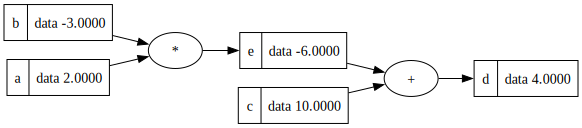

In [ ]:
draw_dot(d)

Ora aggiungeremo un'ultima operazione, ovvero una moltiplicazione tra `d` e una nuova variabile `f`, per creare `L`

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

Vediamo ora il grafico di queste operazioni:

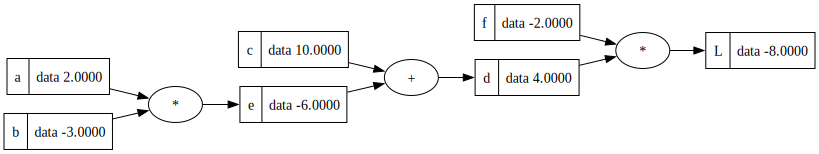

In [ ]:
draw_dot(L)

Abbiamo dunque creato e rappresentato graficamente un forward pass, ovvero una serie di operazioni dall'inizio fino al raggiungimento di un risultato. In questo caso, l'output del forward pass è il valore `-8.0`.

<a name="s3"></a>
## **3 - Definizione della classe `Value` per il Backward Pass**

**Il passaggio successivo è strutturare il backward pass (ovvero la back propagation) per calcolare i gradienti.**

Per fare la back propagation, si partirà dalla fine, calcolando a ritroso i gradienti di tutti i valori intermedi, ovvero verrà calcolata la derivata di `L` rispetto ad ogni valore (ovvero la derivata di `L` rispetto ad `L`, la derivata di `L` rispetto ad `f`, la derivata di `L` rispetto ad `d`, la derivata di `L` rispetto ad `e`, e così via fino al primo elemento, ovvero `a`).

---

*Quando arriveremo a parlare delle reti neurali, sarà molto importante analizzare la derivata della funzione di perdita in relazione ai pesi della rete neurale ("L" infatti sta per "Loss Function"). Infatti, `a`, `b`, `c`, `d` ed `f` ora sono solamente dei valori, ma in seguito rappresenteranno i pesi della rete neurale.*

---

Aggiungiamo quindi una variabile all'interno della classe `Value`, che rappresenterà la derivata di `L` rispetto a ciascun valore, salvando il valore.
Inizialmente la rete avrà i gradienti inizializzati al valore `0.0`, indicando che nessun nodo ha effetto sull'output della rete al termine del forward pass **(questo è molto importante, in quanto i gradienti devono essere calcolati solamente in fase di back propagation, utilizzati per modificare i valori al fine di ridurre la perdita e poi resettati a zero. Approfondiremo questo concetto nei capitoli successivi)**.

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # il valore iniziale del gradiente è impostato a zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

Modifichiamo il codice del grafico per aggiungere l'etichetta, e dunque poter vedere il valore del gradiente all'interno del grafico.

In [ ]:
from graphviz import Digraph

def trace(root):
  # costruisce un insieme di tutti i nodi e gli archi in un grafo
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = da sinistra a destra

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # per qualsiasi valore nel grafo, crea un nodo rettangolare ('record') per esso
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # se questo valore è il risultato di qualche operazione, crea un nodo op per esso
      dot.node(name = uid + n._op, label = n._op)
      # e collega questo nodo ad esso
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # collega n1 al nodo op di n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Inizialmente, il valore dei gradienti sarà pari a zero per tutti gli elementi, poiché non ancora è stata effettuata la back propagation

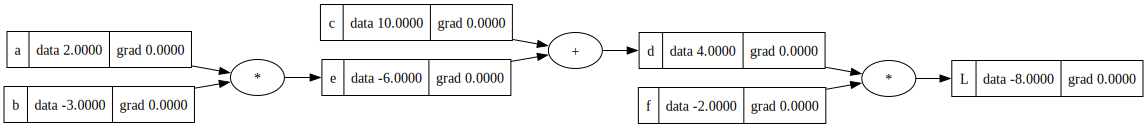

In [ ]:
draw_dot(L)

<a name="s4"></a>
## **4 - Svolgimento della Back Propagation**

Per comprendere a fondo la back propagation, la faremo manualmente, passo dopo passo.

Calcoleremo, dunque, a ritroso, le derivate di `L` rispetto a tutti gli elementi, ovvero tutti i gradienti.

#### **a) Gradiente di L**

Il gradiente di `L` (ovvero la derivata di `L` rispetto ad `L`) è `1`, quindi possiamo aggiornare direttamente il gradiente di `L`

In [ ]:
L.grad = 1

Possiamo quindi osservare sul grafico che il gradiente di `L` è stato aggiornato

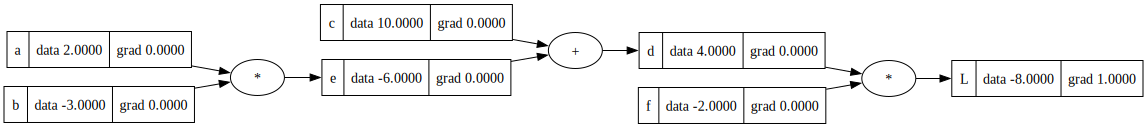

In [ ]:
draw_dot(L)

#### **b) Gradiente di `d` ed `f`**

Sapendo che `L = f * d`, se deriviamo `L` rispetto a `d` otteniamo `f`; se deriviamo `L` rispetto a `f` otteniamo `d`.
```
dL/df = d = -2.0

dL/dd = f = 4.0
```
Aggiorniamo quindi i gradienti di `f` e `d`

In [ ]:
d.grad = -2.0
f.grad = 4.0

Aggiorniamo il grafico

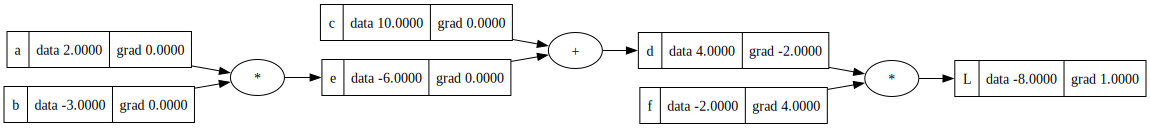

In [ ]:
draw_dot(L)

#### **c) Gradiente di `c` e `e`**

Ora passiamo alla derivata di `L` rispetto a `c` e la derivata di `L` rispetto a `e`.
```
L = d * f

d = c + e

dL/dc = ((dd/dc) * f) + (d * (df/dc)) = 1*f + d*0 = f = -2
```
Che sarebbe uguale al gradiente di `d`.

che sarebbe l'equivalente di:
```
dL/dc = dL/dd * dd/dc = 1*f * 1 = -2
```
Un processo equivalente può essere fatto per `e`:

```
dL/de = ((dd/de) * f) + (d * (df/de)) = 1*f + d*0 = f = -2
```
Che sarebbe uguale al gradiente di `d`.

che sarebbe l'equivalente di:
```
dL/de = dL/dd * dd/de = 1*f * 1 = -2
```

Dunque, **nel caso delle addizioni, i gradienti vengono solamente passati, senza alcuna modifica**.

Aggiorniamo quindi i gradienti e il grafico.

In [ ]:
c.grad = -2.0
e.grad = -2.0

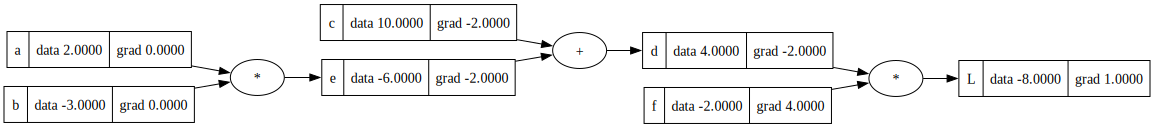

In [ ]:
draw_dot(L)

Infine, resta l'ultimo passaggio della back propagation, ovvero da calcolare i gradienti per `a` e `b`:

#### **d) Gradiente di `a` e `b`**

Sapendo che:

```
dL/da = dL/dc * dc/da = dL/dd * dd/dc * dc/da

L = d * f

d = c + e

e = a * b
```

Possiamo calcolare le derivate:

```
dL/da = ((dd/da) * f) + (d * (df/da)) = (dd/da) * f

dd/da = dc/da + da/da * b + db/da * a

dL/da = (dc/da + da/da * b + db/da * a) * f = (0 + 1*b + 0*a) * f = b * f = (-3.0) * (-2.0) = 6.0
```

Similarmente, per `b`, si avrebbe:
```
dL/db = (0 + 0*b + 1*a) * f = b * f = (2.0) * (-2.0) = -4.0
```
&nbsp;

---

&nbsp;

**Il tutto poteva essere calcolato in maniera più semplice tramite la regola della catena**, nel seguente modo:

```
dL/da = (dL/de) * (de/da)
```

Questo calcolo è molto semplice poiché abbiamo già tutti i valori disponibili, poiché `dL/de` altro non è il gradiente calcolato precedentemente nel passaggio "c", e `de/da` è calcolabile facilmente:

```
dL/da = e.grad * d(a*b)/da = e.grad * (1*b + a*0) = e.grad * b.data = (-2.0) * (-3.0) = 6.0
```

Similarmente, per `dL/db`, si avrebbe

```
dL/db = e.grad * a.data = (-2.0) * (2.0) = -4.0
```
&nbsp;

---
&nbsp;

Aggiorniamo quindi i gradienti e il grafico.

In [ ]:
a.grad = 6.0
b.grad = -4.0

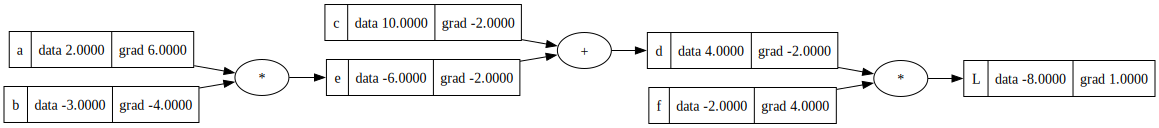

In [ ]:
draw_dot(L)

Sarebbe stato possibile calcolarlo anche in maniera più diretta, utilizzando la definizione di derivata, aggiungendo un incremento `h` a ciascun valore di cui si voleva ottenere il gradiente, utilizzando il seguente codice (ad esempio, per calcolare il gradiente di `a`).

&nbsp;

---

*Poiché questo è solo un esempio informativo, il tutto verrà eseguito all'interno di una variabile `lol()` per fare in modo che i parametri non vengano effettivamente modificati per il resto del codice.*

---

&nbsp;

In [ ]:
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data # il ".data" fa in modo che venga estratto solo il valore di L, non tutto il nodo

    a = Value(2.0, label='a')
    a.data += h # aggiunta di "h" al valore di "a"
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h) # indica il gradiente di "a", ovvero la derivata di "L" rispetto ad "a"

lol()

6.000000000021544


Come si può vedere, anche con questo metodo, il risultato del gradiente di `a` è uguale a `6.0`.

**Abbiamo quindi visto che la back propagation altro non è che l'iterazione della regola della catena per calcolare, a ritroso, le derivate parziali di ogni nodo.**

<a name="s5"></a>
## **5 - Addestramento**

Ora che abbiamo la rete con tutti i gradienti, sappiamo come ogni elemento della rete influisce sul risultato.

Facciamo quindi delle prove per capire il processo di apprendimento della intelligenza artificiale, provando noi stessi ad apprendere come dovremmo modificare i valori di input per far, ad esempio, aumentare il valore di output.

Poiché il nostro scopo è di far aumentare `L`, dobbiamo modificare i valori nella direzione del gradiente, che significa aggiungergli una percentuale del valore del gradiente.

La percentuale altro non è che lo step, ovvero di quando vogliamo muoverci nella direzione del gradiente. Più lo step sarà grande, più si arriverà presto al risultato, aumentando però anche il rischio di superare l'obiettivo e di non riuscire a convergere ad esso.  
&nbsp;

---

&nbsp;

Di seguito, per comprendere meglio questi concetti, osserveremo alcuni semplici esempi visivi, adattati dalla lezione di **Hunar Ahmad**, PhD: *Machine Learning From Zero to GPT in 40 Minute* (disponibile [qui](https://www.youtube.com/watch?v=l-CjXFmcVzY&list=LL&index=18&t=602s)).

Iniziamo partendo da una posizione, e volerci muovere verso una destinazione obiettivo. Il gradiente ci fornisce l'informaizone della direzione, ma sta a noi scegliere di quanto muoverci in quella direzione ad ogni iterazione dell'addestramento.

Ipotizziamo quindi di effettuare degli step grandi:

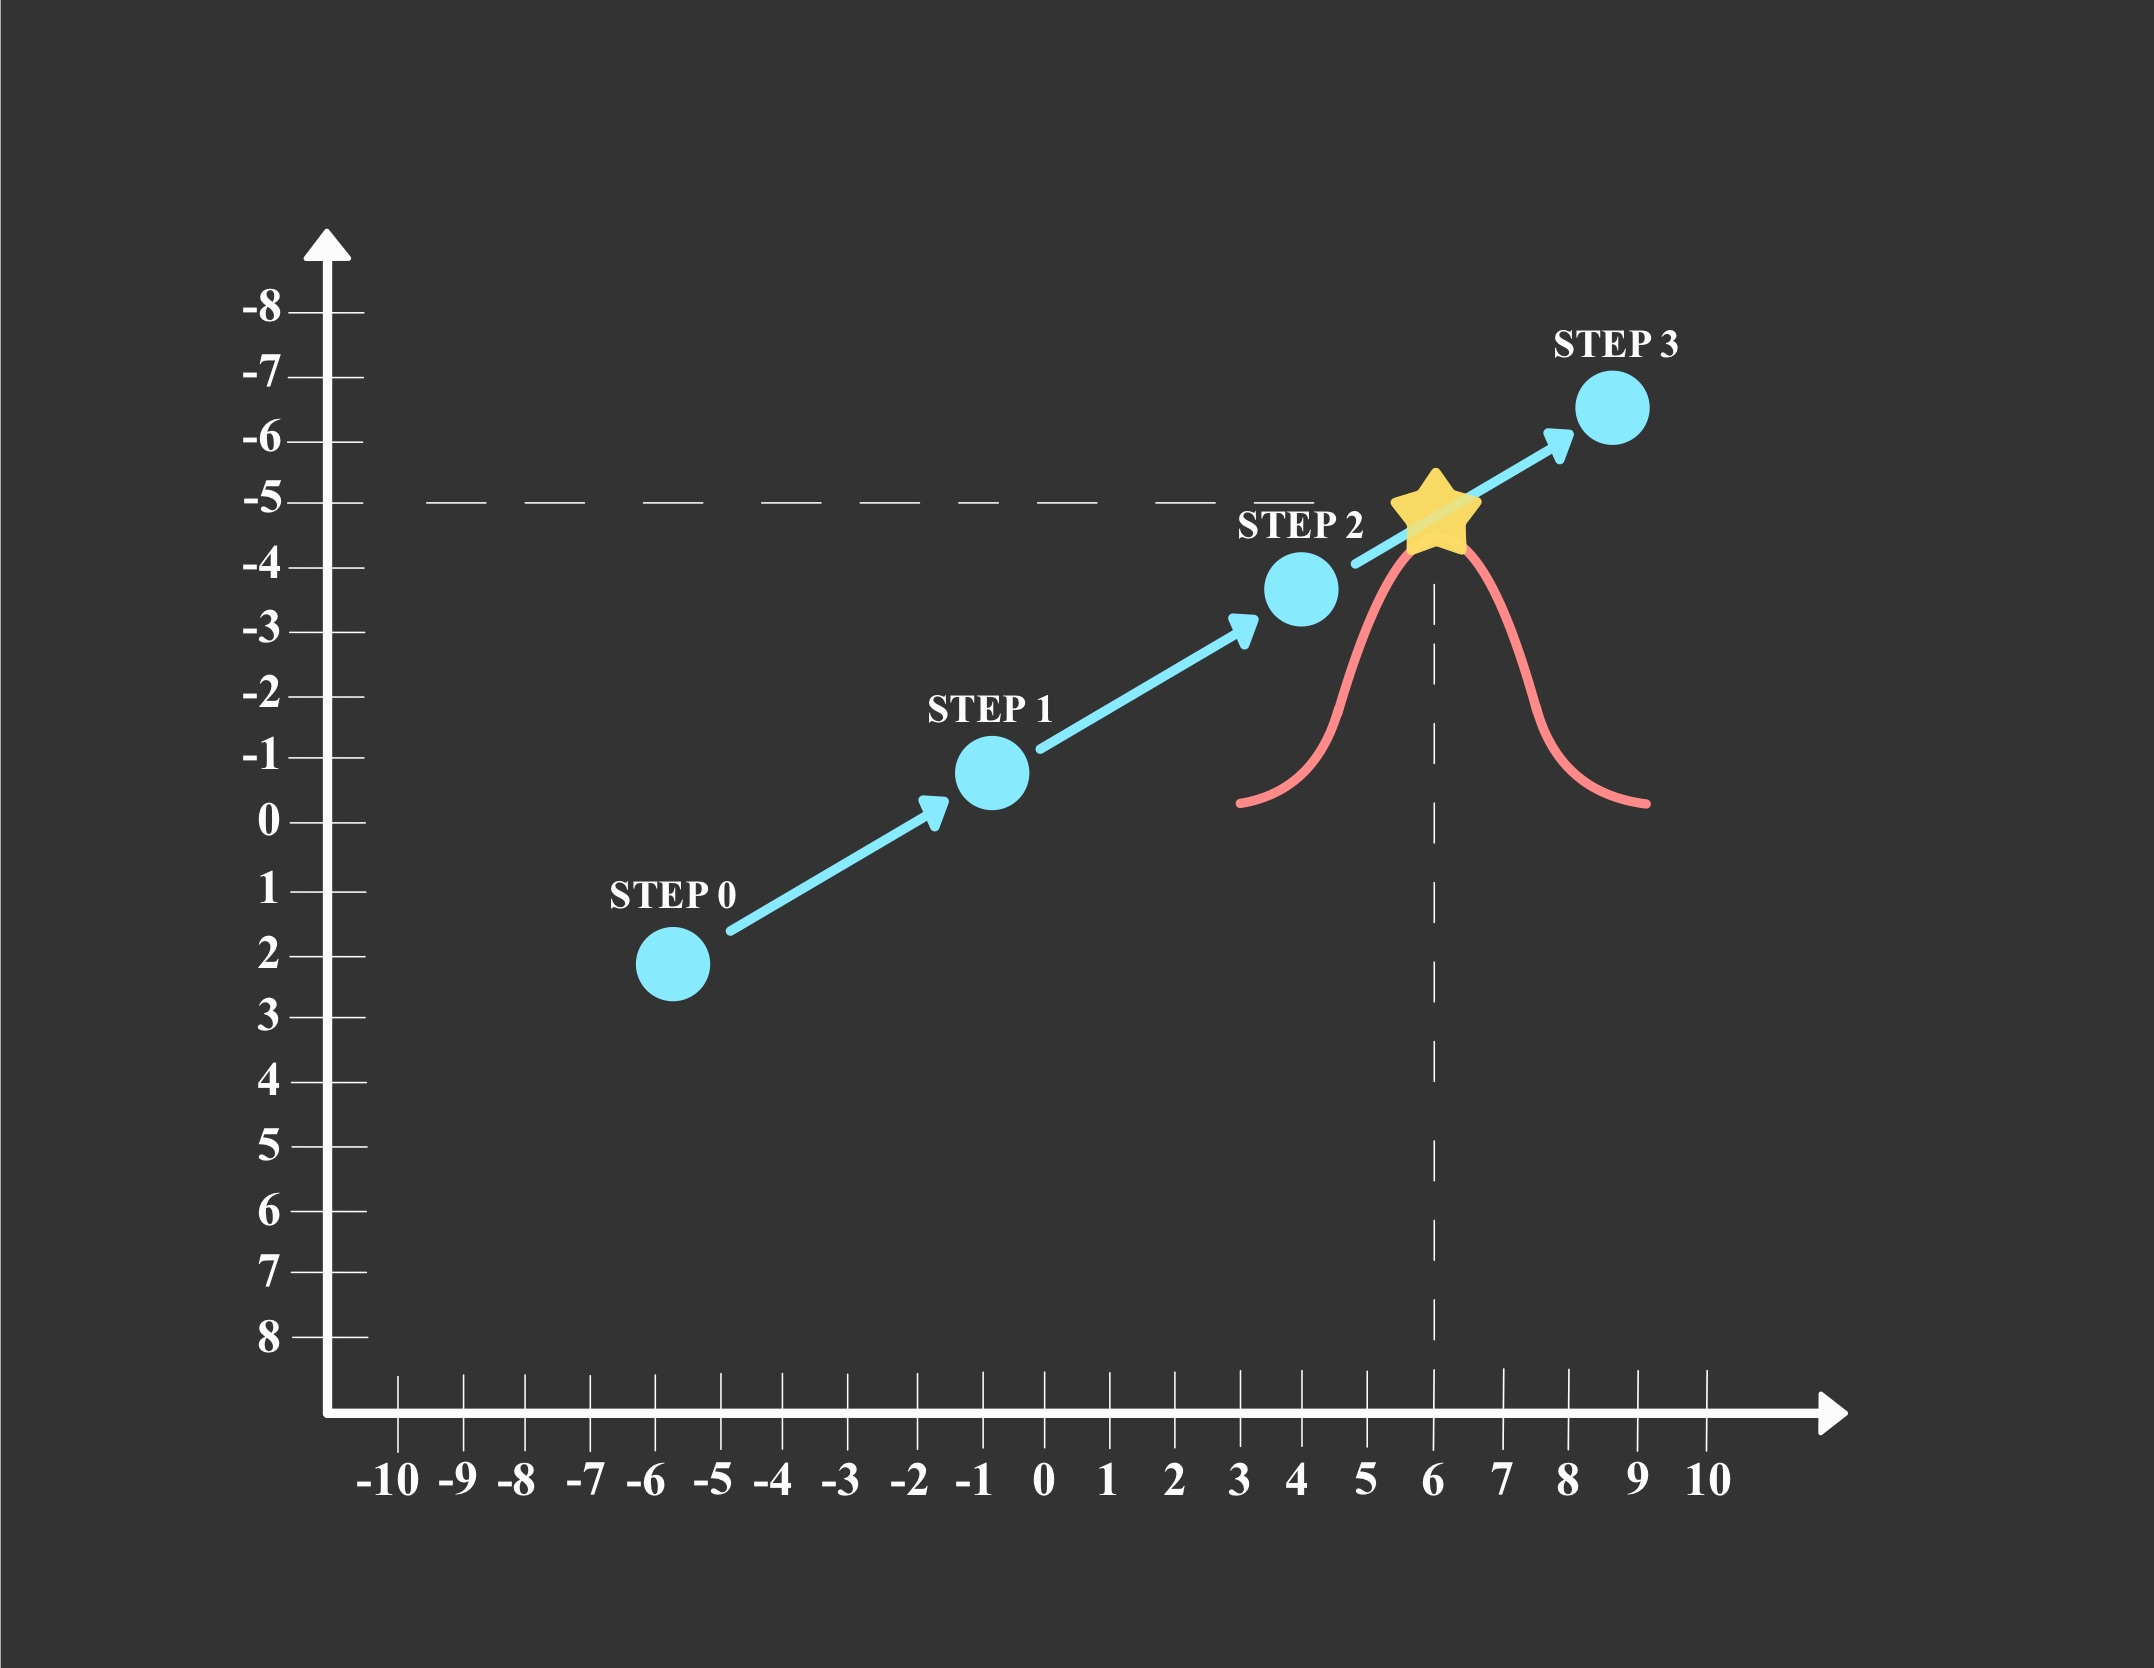

in questo caso, con due iterazioni di addestramento non si è arrivati all'obiettivo, richiedendo quindi un terzo step. Ciò però ha portato al superamento dell'obiettivo.  
Proviamo a proseguire l'addestramento per altre due iterazioni:

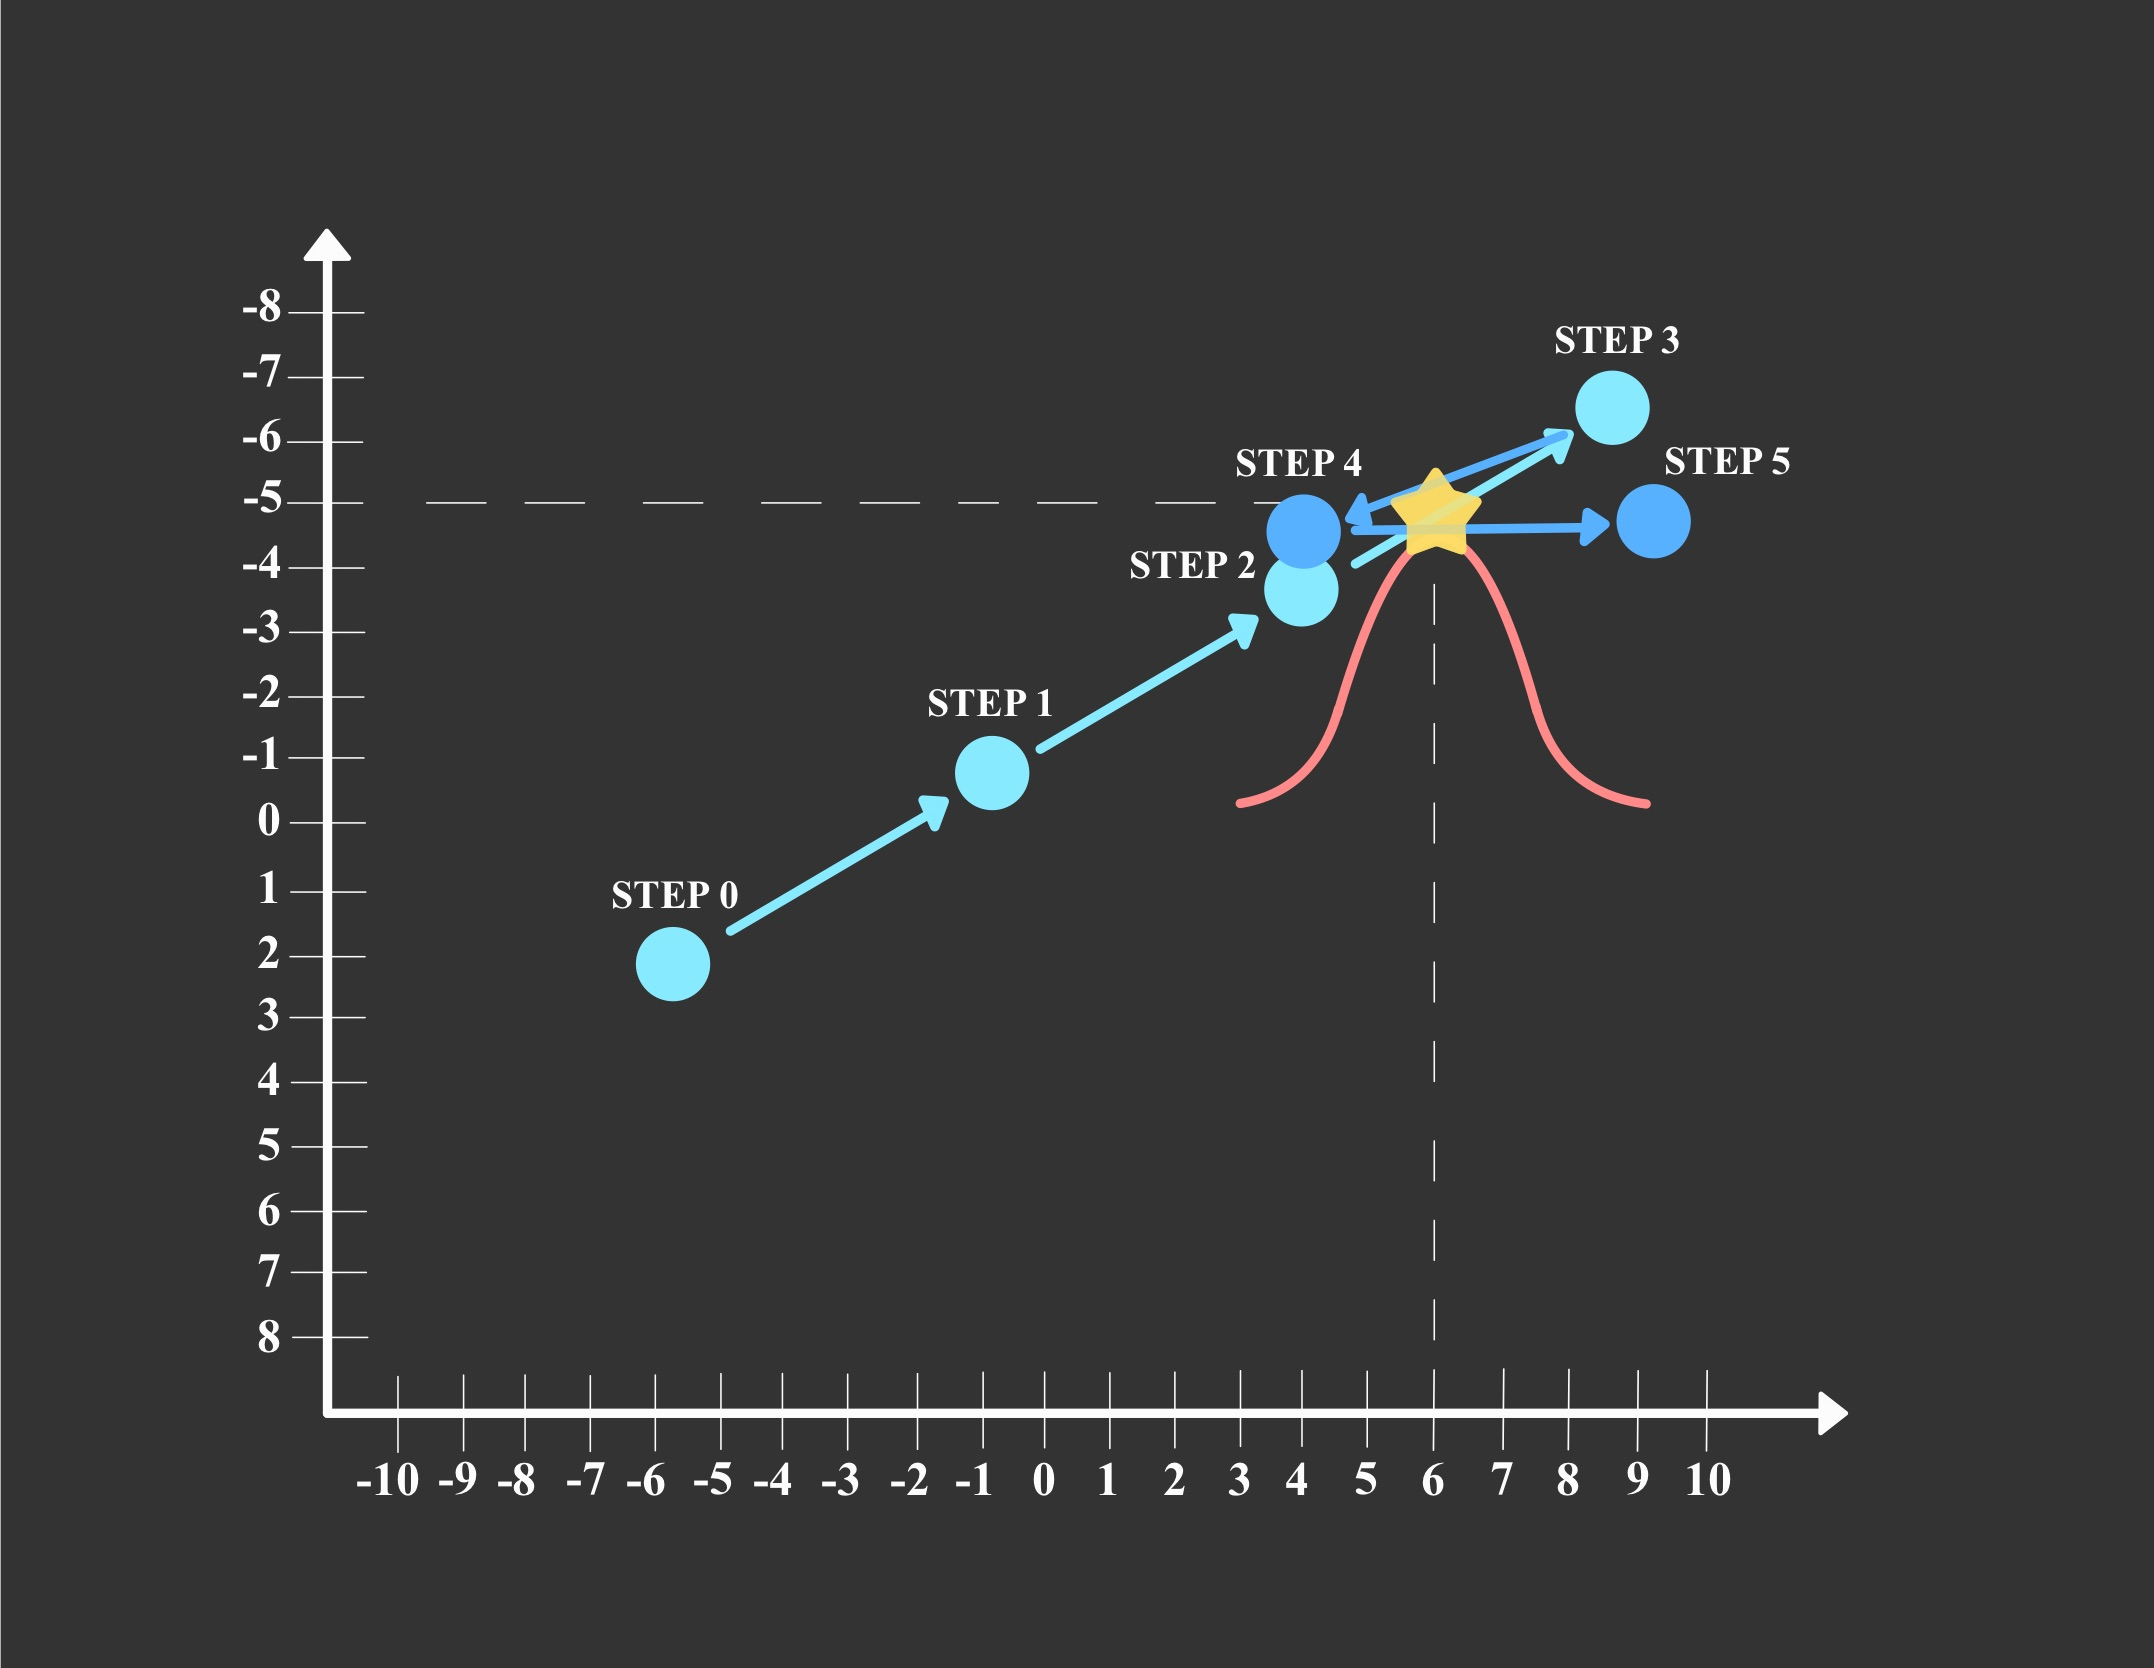

Essendo lo step grande, non riusciamo a convergere al risultato.

Proviamo ora a ripetere l'intero processo. utilizzando uno step più piccolo.

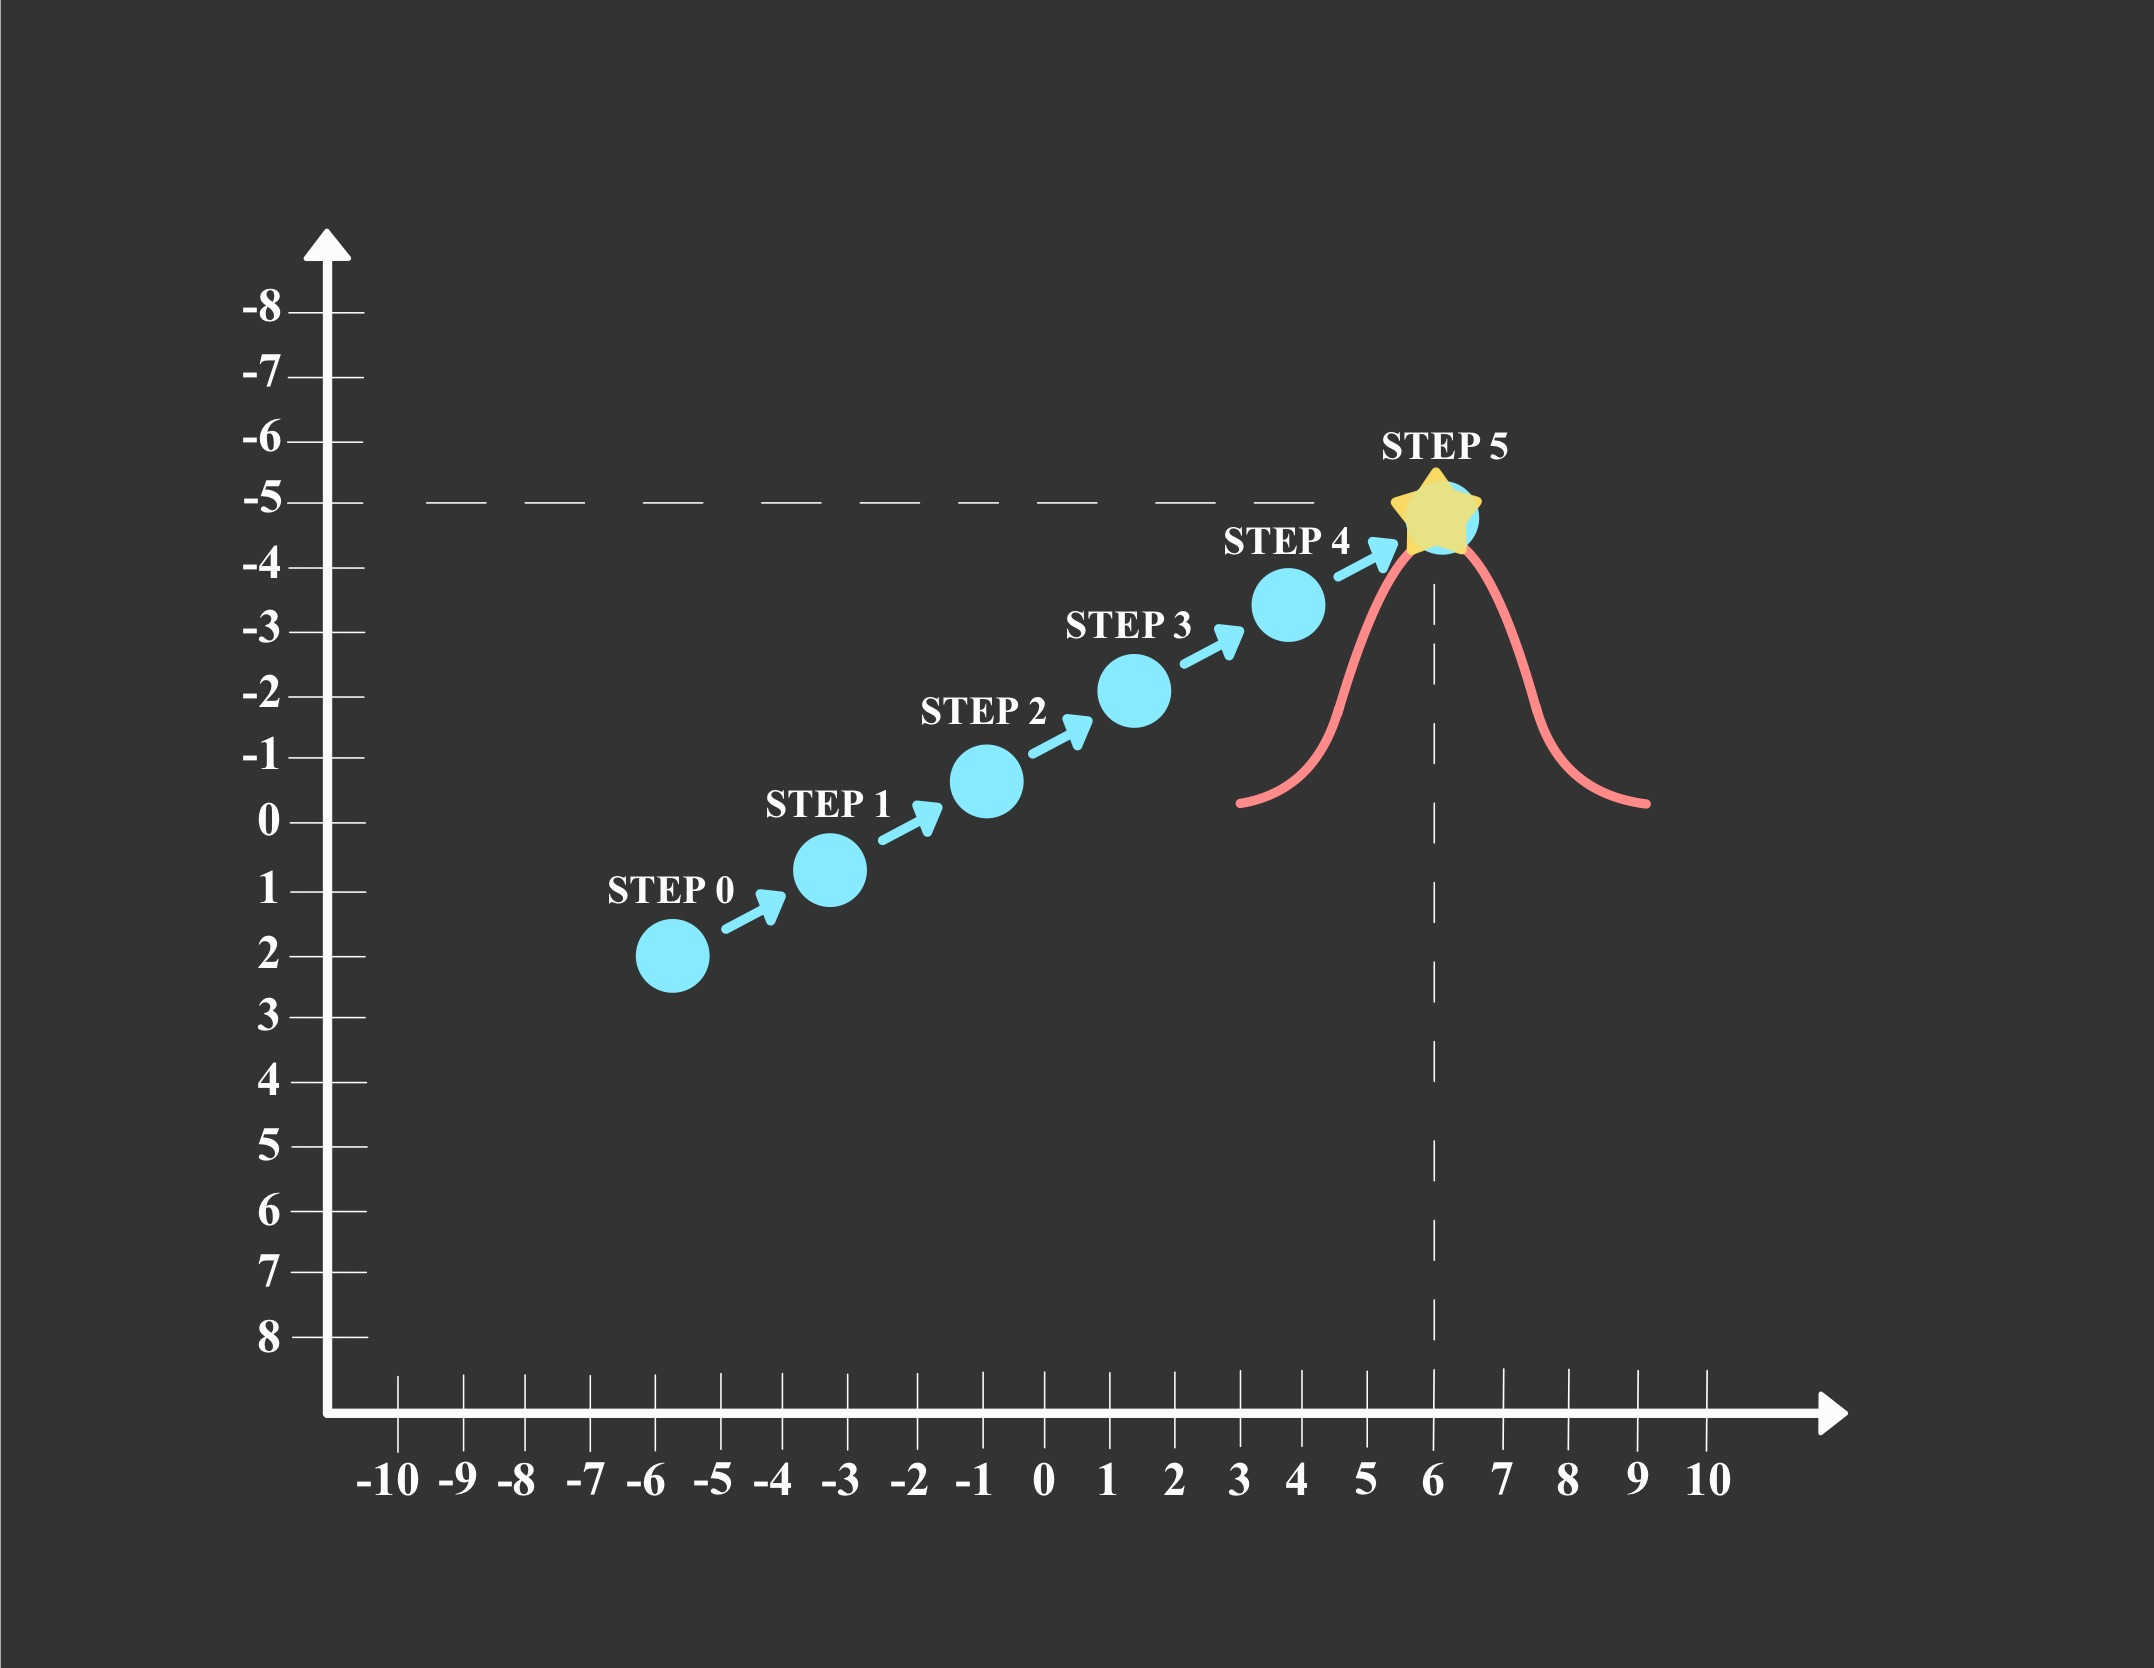

In questo caso, per arrivare al risultato, sono state necessarie 5 iterazioni di addestramento, ma si è riusciti a convergere molto meglio al risultato.

&nbsp;

---

Tornando al codice, proviamo ad effettuare uno step in direzione del gradiente, per tutte le variabili di cui abbiamo il controllo, ovvero `a`, `b`, `c`, `f` e, successivamente, eseguiamo un altro forward pass per calcolare `L` nuovamente.

Avendo seguito la direzione dei gradienti, ci aspettiamo quindi che `L` incrementi.

In [ ]:
# step nella direzione dei gradienti delle variabili di input
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


Come previsto, il valore di `L` è aumentato, assumendo ora il valore di `-7.3` (partendo da un valore pari a `-8.0`).

<a name="s6"></a>
## **6 - Introduzione alle Reti Neurali**
#### **Neuroni, pesi, bias, funzione di attivazione, back propagation**

Passeremo ora ad un esempio più complesso, effettuando manualmente la back propagation attraverso un neurone.

Un neurone artificiale è fatto come segue:

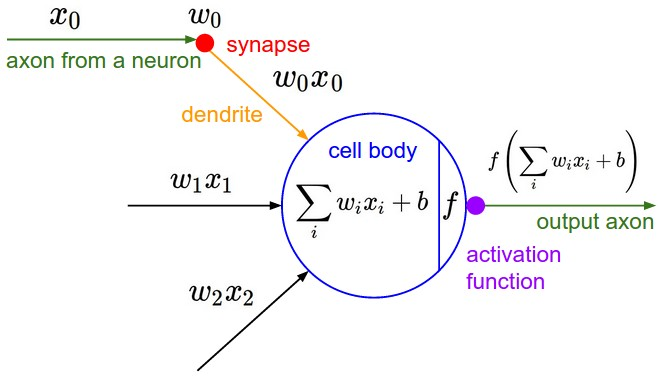

Fonte immagine: *CS231n Convolutional Neural Networks for Visual Recognition*, disponibile [qui](https://cs231n.github.io/neural-networks-1/)

Come illustrato nella figura, un neurone può ricevere molteplici input `xi`, ciascuno con un peso `wi`.
Per passare un valore allo strato successivo, il neurone dovrà attivarsi. Ciò viene determinato dalla funzione di attivazione.

La funzione di attivazione è una funzione che schiaccia in un intervallo i valori risultanti sul neurone (l'intervallo è variabile a seconda della funzione scelta). Se dopo questa operazione il risultato raggiunge un determinato valore, allora il neurone si attiverà, passando allo strato successivo il valore schiacciato dalla funzione di attivazione.

L'attivazione o meno di un neurone dipende anche da un valore di bias, che si sommerà ai vari input moltiplicati per i pesi, prima di passare all'interno della funzione di attivazione.

Il bias rappresenta lo stato di "eccitazione" iniziale del un neurone, ovvero con quanta probabilità il neurone si attiva a prescindere dall'input ricevuto.

Possono essere scelte diverse funzioni di attivazione, per questo esempio utlizzeremo la tangente iperbolica (`tanh`, contenuta all'interno della libreria `numpy`).

Per maggiore chiarezza, rappresentiamo ora, come esempio, un grafico della funzione tangente iperbolica (per un intervallo di valori che vanno da `-5` a `5`):

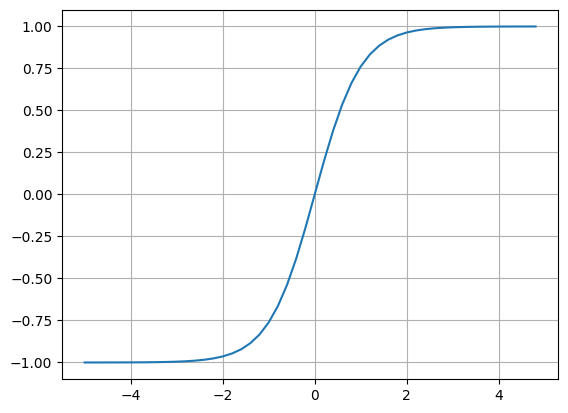

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Come si può vedere la funzione di attivazione schiaccia i risultati, portandoli nell'intervallo che va da `-1` a `+1`.

Possiamo dunque procedere con il nostro esempio.

Creiamo due neuroni, ciascuno con un proprio valore `xi`, e peso `wi` (scelti arbitrariamente per l'esempio), e connettiamoli in un neurone di arrivo. Sommiamo quindi il bias e vediamo il risultato in output (senza implementare la funzione di attivazione).

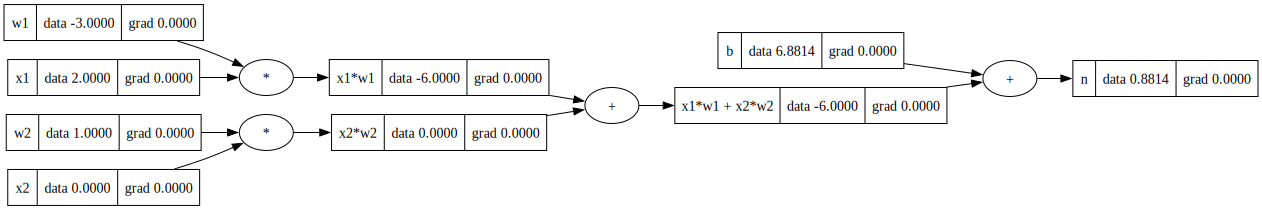

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias del neurone
b = Value(6.8813735870195432, label='b') # valore scelto arbitrariamente, per ottenere risultati più puliti per questo esempio

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # è il risultato sul neurone di arrivo, prima di essere schiacciato dalla funzione di attivazione

draw_dot(n)

Il forward pass produce dunque un output `n`. Il valore di output non ancora è stato sottoposto alla funzione di attivazione `tanh`.

Per come abbiamo definito la classe `Value`, essa supporta solamente addizioni e moltiplicazioni. Poiché la funzione di attivazione `tanh` contiene degli esponenziali al suo interno, è necessario aggiornare la classe `Value` inserendo anche questa possibilità.

Effettueremo invece un metodo differente, implementando direttamente la funzione `tanh` al suo interno, così non necessitiamo di importare ogni singola operazione che la compone.

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # il valore iniziale del gradiente è zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self): # definizione della funzione per gestire la funzione di attivazione
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

Possiamo quindi rieffettuare il calcolo, questa volta mostrando il valore `o`, che indica l'output dopo essere passato per la funzione di attivazione.

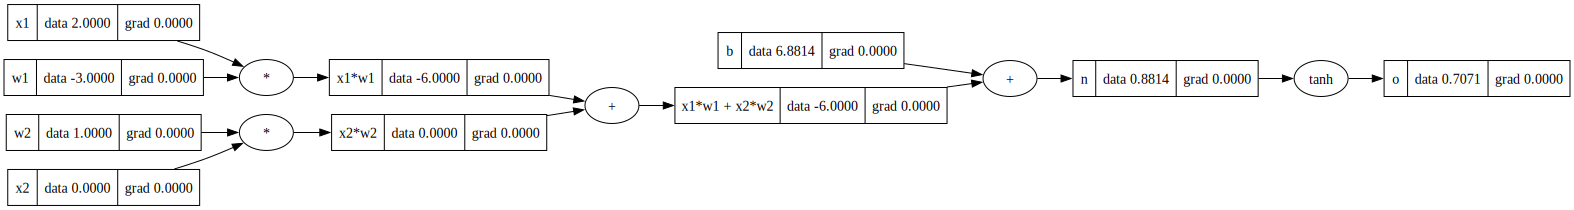

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' # è il risultato sul neurone di arrivo, prima di essere schiacciato dalla funzione di attivazione
o = n.tanh(); o.label = 'o'     # risultato di n dopo essere passato per la funzione di attivazione

draw_dot(o)

Come fatto per l'esempio precedente, faremo ora la back propagation manualmente, a partire dall'ultimo nodo, utilizzando lostesso procedimento (ovvero calcolando le derivate parziali dell'output rispetto ai vari nodi della rete).

---

*È importante tenere in mente che, nel caso di una rete neurale, ciò di cui ci interessa davvero calcolare i gradienti sono i pesi, in quanto saranno loro a cambiare, non i valori di input.*

---

In [ ]:
# derivata di o rispetto ad o
o.grad = 1.0

# derivata di o rispetto ad n
# o = tanh(n)
# do/dn = d(tanh(n))/dn
# la derivata rispetto ad n di tanh(n) è uguale a 1 - tanh(n)**2, quindi do/dn = 1 - o**2 = 0.5
n.grad = 0.5

# adesso n è collegato ai nodi precedenti tramite una addizione dunque, come visto in precedenza, il gradiente non cambia
b.grad = 0.5
x1w1x2w2.grad = 0.5

# anche x1w1x2w2 è collegato ai nodi precedenti tramite una addizione, quindi il gradiente viene passato anche in questo caso
x1w1.grad = 0.5
x2w2.grad = 0.5

# infine, x1w1 e x2w2 sono collegati ai nodi precedenti tramite una moltiplicazione (come prima, si utilizza la regola della catena)
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad



Aggiorniamo il grafico, che mostra i gradienti appena calcolati tramite la back propagation.

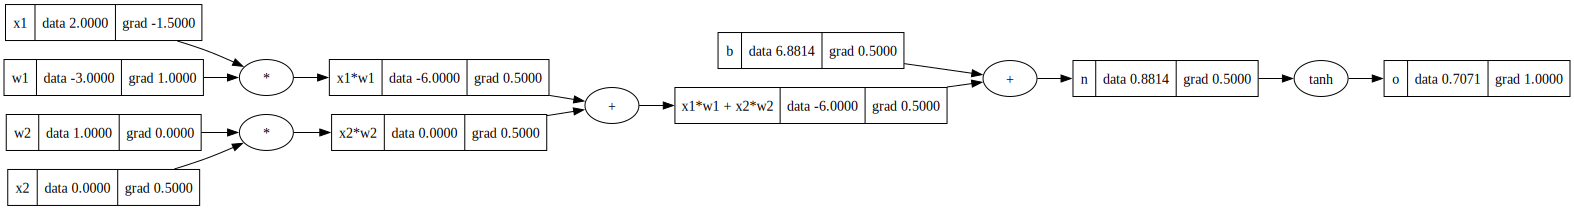

In [ ]:
draw_dot(o)

Osserviamo come il gradiente di `w2` sia zero. Il gradiente indica la direzione in cui dovrebbe cambiare il valore per fare in modo che l'output cresca. In questo caso, visto che `w2` viene moltiplicato per `x2`, che ha valore pari a zero, è corretto che il suo gradiente sia nullo, in quanto `w2` non influenzerebbe mai il risultato, per `x2 = 0`.

Quindi, se volessimo incrementare il valore dell'output, dovremmo incrementare il valore del peso `w1` (in quanto il gradiente è positivo), di una quantità proporzionale al gradiente.

<a name="s7"></a>
## **7 - Automatizzazione della Back Propagation**

Poiché effettuare la back propagation manualmente richiede parecchio tempo, includeremo logica per la backpropagation all'interno della classe `Value`.

Lo faremo definendo una funzione `_backward` per ciascuna operazione aritmetica e funzione di attivazione (in questo caso, l'addizione, la moltiplicazione e la tangente iperbolica). Queste funzioni `_backward` sono progettate per calcolare e propagare i gradienti ai valori nodi predecessori attraverso l'utilizzo della regola della catena.

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # il valore iniziale del gradiente è zero
        self._backward = lambda: None # di default non fa nulla
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # definiamo cosa dovrebbe fare la funzione backward se viene chiamata
        # la funzione backward dovrebbe partire da out.grad, e propagare a self.grad e other.grad
        # essendo una addizione, propaga semplicemente il gradiente che gli arriva, senza fare nulla
        # si applica la regola della catena
        def _backward():
            # il "+=" serve ad accumulare i gradienti, ovvero a prevenire che, nel caso di nodi con lo stesso nome (oppure più nodi collegati a ritroso allo stesso nodo) vengano sovrascritti i gradienti
            self.grad += 1.0 * out.grad  # derivata del nodo passato rispetto a se stesso (essendo una addizione rimane solo la derivata di se stesso, ovvero 1.0) * gradiente del nodo appena passato
            other.grad += 1.0 * out.grad # stessa cosa

        out._backward = _backward # la funzione non ha le parentesi finali perché non vogliamo eseguirla, ma conservarla per eseguirla quando viene chiamata

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        # creeremo anche la funzione backward per le moltiplicazioni, in questo caso i gradienti cambieranno
        def _backward():
            self.grad += other.data * out.grad # derivata del nodo appena passato rispetto a se stesso (ovvero il valore .data degli altri) * il gradiente del nodo appena passatoi
            other.grad += self.data * out.grad # l'opposto, nel senso che l'altro valore avrà la derivata di self invece che di se stesso

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        # creeremo anche la funzione backward per la funzione di attivazione
        def _backward():
            self.grad += (1.0 - t**2) * out.grad # derivata della funzione tanh, per il gradiente del nodo precedente (che, nel caso dell'ultimo nodo, è 1.0)

        out._backward = _backward

        return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

Ora che abbiamo definito anche la funzione per la back propagation possiamo reinizializzare i valori e i gradienti, e testare la funzione `backward`.

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

Prima di effettuare la back propagation a partire dal nodo `o`, dobbiamo ricordarci che abiamo inizizializzato i gradienti a zero (compreso quello dell'ultimo nodo). Se dunque utilizzassimo direttamente la funzione che abbiamo definito per iniziare la back propagation, il risultato sarebbe zero (perchè ci sarebbe la  moltiplicazione per zero). È quindi necessario reinizializzare l'ultimo gradiente ad un valore pari ad `1`, prima di applicare la funzione `backward`.

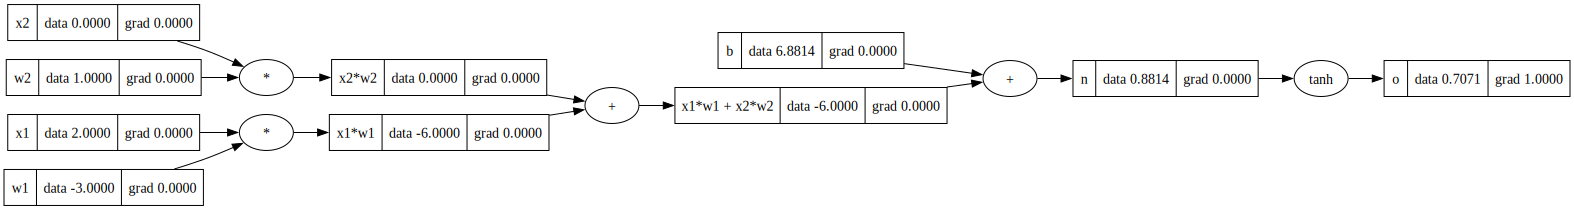

In [ ]:
o.grad = 1.0
draw_dot(o)

Ora possiamo applicare la funzione ad `o` per far propagare il gradiente al nodo `n`

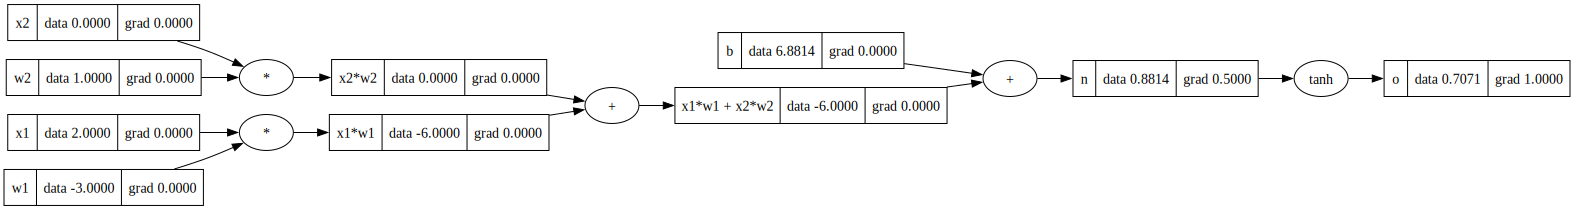

In [ ]:
o._backward()
draw_dot(o)

Possiamo dunque proseguire su tutti gli altri nodi

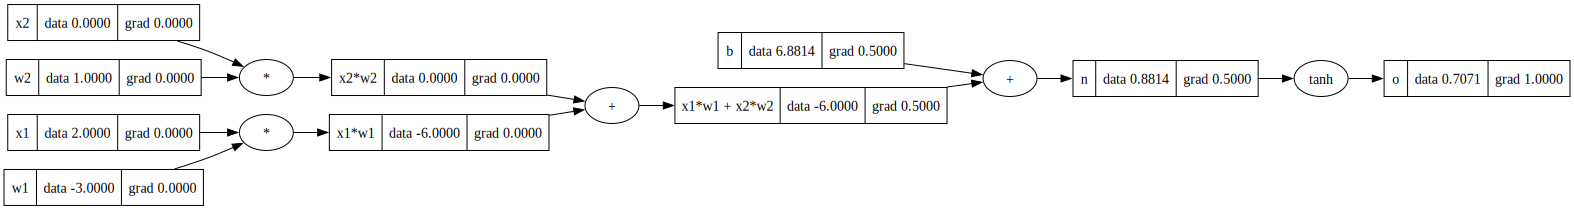

In [ ]:
n._backward()
draw_dot(o)

Se applichiamo la funzione su `b`, che non ha nodi su cui propagare il gradiente, non accade nulla, in quanto abbiamo impostato il valore di default della funzione `backward` in modo che non faccia nulla in questi casi.

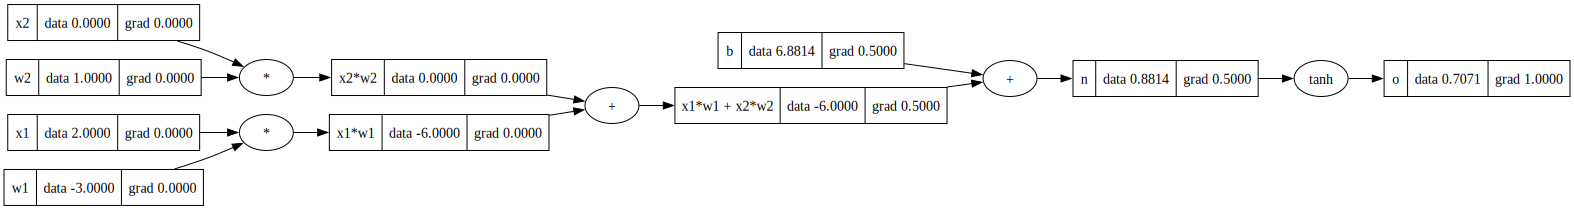

In [ ]:
b._backward()
draw_dot(o)

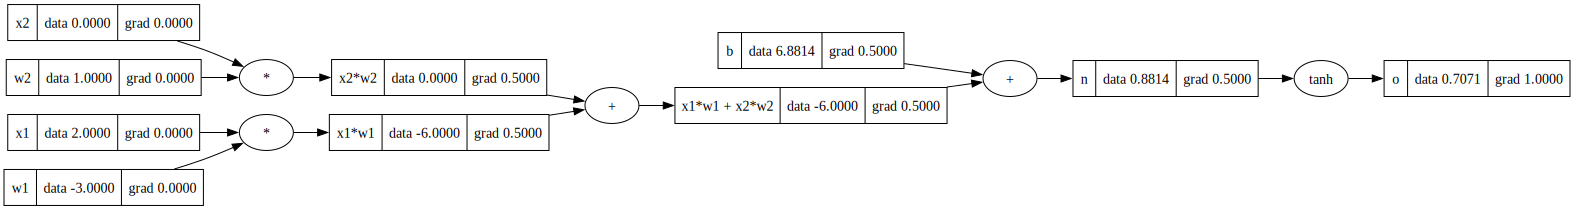

In [ ]:
x1w1x2w2._backward()
draw_dot(o)

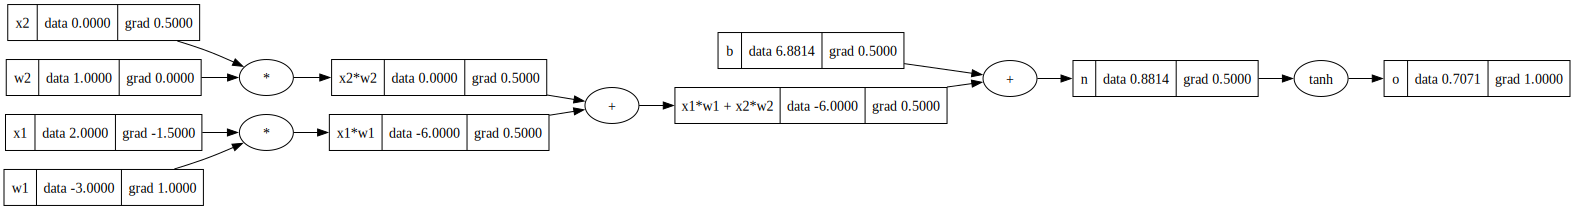

In [ ]:
x2w2._backward()
x1w1._backward()
draw_dot(o)

Abbiamo dunque ottenuto lo stesso risultato di quando abbiamo effettuato la back propagation manualmente.

L'unica cosa che manca è fare in modo che la back propagation avvenga in automatico. Per farlo, bisogna fare in modo che la back propagation non avvenga mai prima del completamento di tutte le dipendenze per un dato nodo. Questo ordine di esecuzione viene chiamato ordine topologico (topological sort), che indica solamente il verso di esecuzione delle operazioni (ovvero, da sinistra verso destra).

Costruiamo quindi un grafico topologico:

In [ ]:
topo = []                 # lista per creare il grafo
visited = set()           # 'visited' terrà traccia dei nodi visitati (inizializzato con un set vuoto)
def build_topo(v):
  if v not in visited:    # controlla se il nodo 'v' è già stato visitato. Se non lo è, il codice procederà a visitarlo.
    visited.add(v)        # se il nodo 'v' non è stato visitato, viene aggiunto al set 'visited'
    for child in v._prev: # il ciclo for passa attraverso tutti i nodi predecessori di 'v' ('prev' sta per previous) tramite un collegamento diretto
      build_topo(child)   # per ogni nodo predecessore applica 'build_topo', quindi sostanzialmente il ciclo iterativamente cerca figli, e salverà 'v' (il genitore) solamente dopo che l'ultimo figlio è stato trovato e salvato
    topo.append(v)        # dopo aver visitato tutti i predecessori di 'v', il nodo 'v' viene aggiunto all'elenco 'topo'
build_topo(o)             # avvia build topo dal nodo 'o', ovvero da dove si vuole far partire la costruzione dell'ordinamento topologico
topo

# ovviamente, per funzionare è necessario che i nodi abbiano l'attributo '_prev', che abbiamo infatti aggiunto all'inizio di questa trattazione, negli oggetti della classe 'Value'

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Se ora azzeriamo nuovamente i gradienti, possiamo applicare la funzione `backward` su tutti i nodi, in ordine topologico inverso, ovvero dall'ultimo al primo.

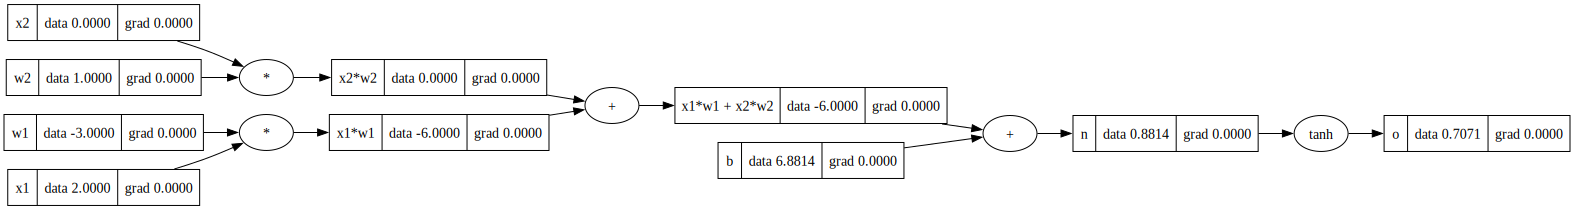

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

Effettuiamo la back propagation in ordine topologico inverso, dopo aver impostato il gradiente di `o` ad `1.0`

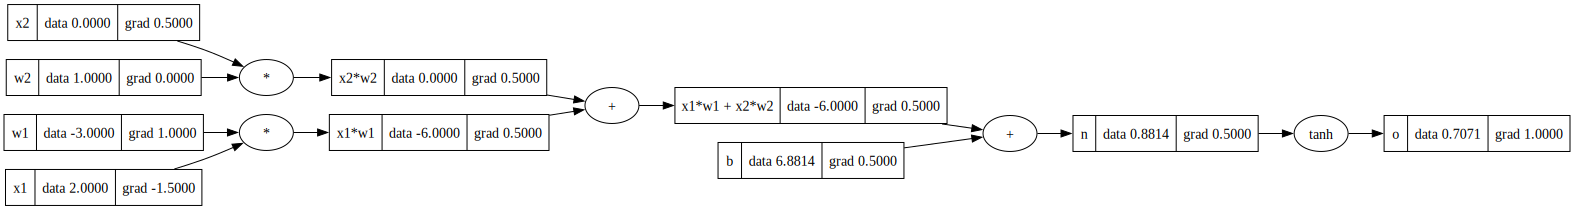

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

draw_dot(o)

Infine, la funzione `topo` può essere incluse nella classe `Value` per non doverla chiamare ogni volta manualmente.

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # il valore iniziale del gradiente è zero
        self._backward = lambda: None # di default non fa nulla
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        # definiamo cosa dovrebbe fare la funzione backward se viene chiamata
        # la funzione backward dovrebbe partire da out.grad, e propagare a self.grad e other.grad
        # essendo una addizione, propaga semplicemente il gradiente che gli arriva, senza fare nulla
        # si applica la regola della catena
        def _backward():
            self.grad += 1.0 * out.grad  # derivata del nodo passato rispetto a se stesso (essendo una addizione rimane solo la derivata di se stesso, ovvero 1.0) * gradiente del nodo appena passato
            other.grad += 1.0 * out.grad # stessa cosa

        out._backward = _backward # la funzione non ha le parentesi finali perché non vogliamo eseguirla, ma conservarla per eseguirla quando viene chiamata

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        # creeremo anche la funzione backward per le moltiplicazioni, in questo caso i gradienti cambieranno
        def _backward():
            self.grad += other.data * out.grad # derivata del nodo appena passato rispetto a se stesso (ovvero il valore .data degli altri) * il gradiente del nodo appena passatoi
            other.grad += self.data * out.grad # l'opposto, nel senso che l'altro valore avrà la derivata di self invece che di se stesso

        out._backward = _backward

        return out

    def tanh(self): # definizione della funzione per gestire la funzione di attivazione
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad # derivata della funzione tanh, per il gradiente del nodo precedente (che, nel caso dell'ultimo nodo, è 1.0)

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

Ora, infine, se resettiamo nuovamente i gradienti, possiamo chiamare la funzione `backward` e la back propagation verrà eseguita in automatico.

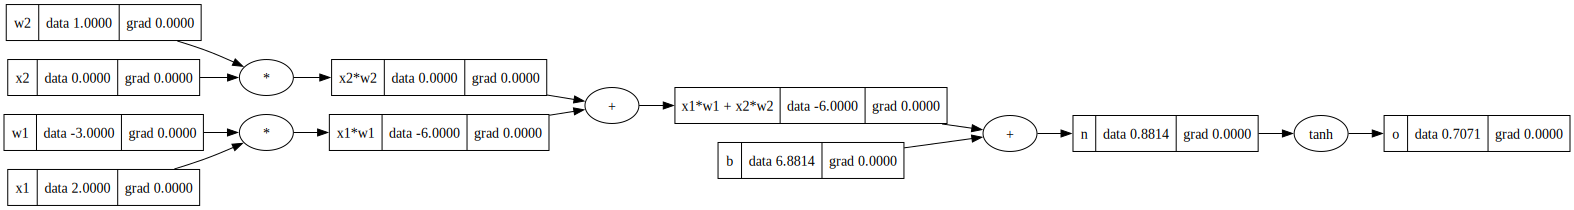

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

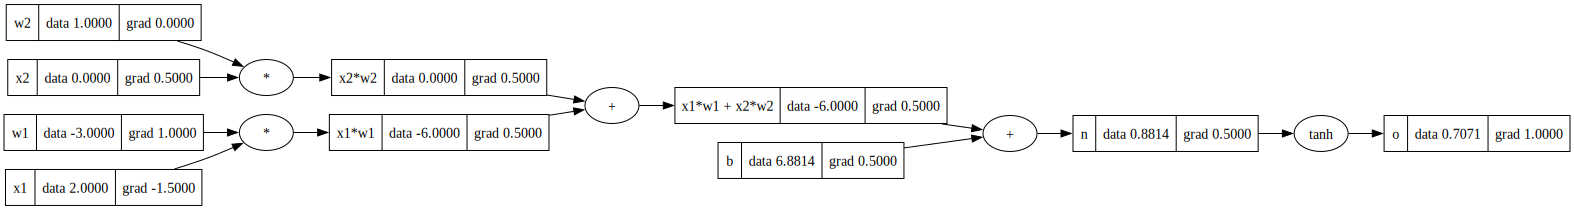

In [ ]:
o.backward()
draw_dot(o)

**Abbiamo dunque automatizzato completamente il forward pass e la back propagation.**

<a name="s8"></a>
## **8 - Implementazioni possibili**

Per completezza, rendiamo la classe `Value` più versatile, facendo in modo che supporti anche altre operazioni. Includiamo anche la possibilità di effettuare calcoli con numeri **non** della classe `Value`.

Facciamo dunque in modo che possano essere effettuate anche operazioni del tipo:

```
a = Value(1.0)   
a + 1
```
Questa operazione restituirebbe un errore, in quanto `1` non appartiene alla classe `Value`, quindi non non esiste un `1.data` da cui prendere il valore per effettuare la somma.

Similarmente, non supporta operazioni di moltiplicazione del tipo:
```
a = Value(1.0)  
a * 1
```
Infine, non supporta nemmeno la moltiplicazione scritta all'inverso, come ad esempio:
```
a = Value(1.0)  
1 * a
```
Poiché leggerebbe `1.__mul__(a)` al posto di `a.__mul__(1)`, e non riuscirebbe ad applicare il metodo `mul` ad `1`.

Per risolvere questi problemi è necessario:  
**1)** Aggiungere la possibilità di riconoscere se `other` è un valore non `Value` e, nel caso, assegnargli un `.data`, sia per le addizioni che per le moltiplicazioni.  
**2)** Provare ad effettuare le moltiplicazioni in un verso e, se non riesce ad effettuarle, scambiare `self` con `other` e riprovare.

Aggiorniamo dunque la classe `Value`:

In [ ]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # il valore iniziale del gradiente è zero
        self._backward = lambda: None # di default non fa nulla
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # derivata del nodo passato rispetto a se stesso (essendo una addizione rimane solo la derivata di se stesso, ovvero 1.0) * gradiente del nodo appena passato
            other.grad += 1.0 * out.grad # stessa cosa

        out._backward = _backward # la funzione non ha le parentesi finali perché non vogliamo eseguirla, ma conservarla per eseguirla quando viene chiamata

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # derivata del nodo appena passato rispetto a se stesso (ovvero il valore .data degli altri) * il gradiente del nodo appena passatoi
            other.grad += self.data * out.grad # l'opposto, nel senso che l'altro valore avrà la derivata di self invece che di se stesso

        out._backward = _backward

        return out

    def __rmul__(self, other): # se self * other non funziona viene mandato in questa funzione, che li inverte
        return self * other

    def tanh(self): # definizione della funzione per gestire la funzione di attivazione
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad # derivata della funzione tanh, per il gradiente del nodo precedente (che, nel caso dell'ultimo nodo, è 1.0)

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

Facciamo alcuni semplici test:

In [ ]:
a = Value(1.0)
a + 1

Value(data=2.0)

In [ ]:
a = Value(1.0)
a * 1

Value(data=1.0)

In [ ]:
a = Value(1.0)
2 * a

Value(data=2.0)

Aggiungiamo ora la possibilità di gestire anche altre operazioni:

**1)** Esponenziali: molto semplici

**2)** Divisioni: verrà utilizzato un metodo più generale, considerando `a/b` come `a*(b**-1)`. Per fare ciò sarà necessario implementare due funzioni, sia quella per la divisione, che quella per elevare alla potenza di `-1`.

**3)** Sottrazioni: verrà scomposto in due parti. La prima parte sarà trasformare la sottrazione in una somma con uno dei due valori, dopo averlo negato (al posto di `a - b` ci sarà `a + (-b)`). Come secondo passaggio dovremo quindi gestire le negazioni, ovvero quando compare un `-` davanti ad un numero si attiverà una funzione che trasformerà, ad esempio, `-b` in `b * (-1)`.

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "per ora supporta solamente le potenze int/float"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad # sarebbe la derivata di x alla n, ovvero nx alla n-1. Poi si moltiplica per il gradiente di per la regola della catena
    out._backward = _backward

    return out

  def __rmul__(self, other): # per gestire self * other di cui 1 dei due numeri non è di classe Value
    return self * other

  def __truediv__(self, other): # per trasformare self / other nella forma self * other**-1
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # # per gestire self - other di cui 1 dei due numeri non è di classe Value
    return self + (-other)

  def __radd__(self, other): # per gestire self + other di cui 1 dei due numeri non è di classe Value
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

Facciamo alcuni semplici test:

In [ ]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [ ]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

Ora possiamo anche scomporre la funzione di attivazione `tanh` nelle sue componenti, ottenendo gli stessi risultati di prima, sia per il forward pass che per il backward pass.

```
tanh(n) = (e**(2n) - 1) - (e**(2n) + 1)
```

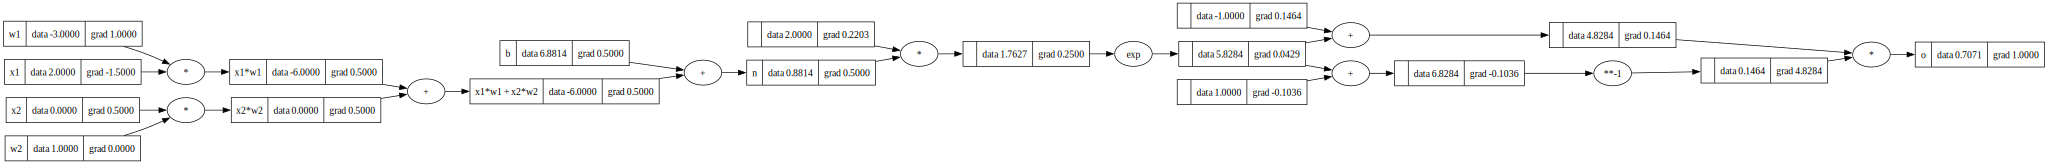

In [ ]:
# x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp() # sarebbe e**(2n)
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

È dunque libera la scelta della granularità delle operazioni da includere, è possibile scomporre ogni funzione nelle varie componenti oppure lasciare le funzioni complesse come tali, facendole gestire alla classe in maniera diretta.

<a name="s9"></a>
## **9 - Addestramento nella pratica: `PyTorch`**

Ora siamo dunque pronti per comprendere come librerie più efficienti, come `PyTorch`, effettuano il forward e backward pass.

Innanzitutto, è importante sottolineare che `PyTorch` utilizza principalmente i tensori, a differenza dei valori scalari impiegati negli esempi precedenti. Per mantenere semplice l'esempio, utilizzeremo tensori che contengono un singolo elemento scalare, rendendo così la situazione molto simile agli esempi passati. Generalmente, però, i tensori possono rappresentare strutture dati più complesse.

In [ ]:
# importiamo la libreria
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True # "require gradients" è necessario perché pytorch di default assume che i nodi di input non ne abbiano bisogno
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True # ".double()" serve solamente a mantenere il formato in float64
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# come per gli oggetti di classe "Value", anche gli oggetti "Tensor" hanno come attributi "data" e "grad"
# vanno però chiamati gli item, che servono ad estrapolare il valore dal tensore per mostrarlo
print(o.data.item()) # questo dovrebbe dare come risultato "data" del nodo di output, ovvero 0.7071

# si effettua la back propagation
o.backward()

# separiamo i seguenti print dal precedente in modo da rendere la visione più chiara
print('---')
# print dei gradienti dei nodi di input
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


I risultati coincidono con quanto calcolato precedentemente

Vediamo la struttura di `o`, per capire come è strutturato il tensore

In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

utilizzando `item()`, possiamo estrapolare il valore di `data`

In [ ]:
o.item()

0.7071066904050358

Una delle comodità di lavorare con `PyTorch` è proprio l'utilizzo dei tensori, che permettono di svolgere molteplici operazioni in parallelo.

Passeremo ora alla creazione di una rete neurale, in maniera compatibile con le API di `PyTorch`.

In [ ]:
import random

# definiremo inizialmente la classe Neuron, per definire i neuroni
class Neuron:

  def __init__(self, nin):                                     # il metodo costruttore init avrà "self" e "nin", ovvero "number of inputs", che indica quanti collegamenti ha in input il dato neurone
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # creerà dei pesi per ciascun collegamento in input (valore casuale tra -1 e +1)
    self.b = Value(random.uniform(-1,1))                       # creerà un singolo bias, che indica lo stato di eccitazione iniziale del neurone (sempre casuale tra -1 e +1)

  def __call__(self, x): # cosa fare quando viene chiamato un dato neurone
    # ad esempio, vediamo cosa accade se __call__ restituisce 0.0
    return 0.0


x = [2.0, 3.0] # array di input

n = Neuron(2)  # creazione di un neurone bidimensionale

# se proviamo a passare l'array di valori al neurone viene chiamata la funzione call (quindi in questo caso dovrebbe restituire 0.0)
n(x)

0.0

Dunque `__call__` definisce il metodo per il forward pass.

Definiamo ora anche gli strati della rete neurale

In [ ]:
import random

class Neuron:

  def __init__(self, nin):                                     # la funzione init avrà "self" e "nin", ovvero "number of inputs", che indica quanti collegamenti ha in input il dato neurone
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # creerà dei pesi per ciascun collegamento in input (valore casuale tra -1 e +1)
    self.b = Value(random.uniform(-1,1))                       # creerà un singolo bias, che indica lo stato di eccitazione iniziale del neurone (sempre casuale tra -1 e +1)

  def __call__(self, x):
    # il forward pass sarebbe w * x + b, ovvero (pesi * valore) + bias
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)    # "zip" associa ciascun input "xi" al corrispondente peso "wi"
    out = act.tanh()                                           # il risultato di w * x + b viene passato alla funzione di attivazione
    return out

# ora definiremo la classe relativa agli strati della rete (layers)
class Layer:

  def __init__(self, nin, nout):                      # nin = numero di input per ciascun neurone nel layer. nout = numero di neuroni nel layer
    self.neurons = [Neuron(nin) for _ in range(nout)] # lista di oggetti Neuron, ciascuno inizializzato con nin input. Il numero di neuroni creati è uguale a nout

  def __call__(self, x):                              # per ogni neurone nel layer applica il metodo call (x è un array di valori di input per il layer)
    outs = [n(x) for n in self.neurons]               # quando un layer viene chiamato con un input x, applica ogni neurone a questo input
    return outs[0] if len(outs) == 1 else outs        # raccoglie l'out di ciascun neurone in una lista (o un solo valore se e presente un solo neurone)


x = [2.0, 3.0]  # valori di input

n = Layer(2, 3) # layer con 3 neuroni, ciascuno dei quali ha 2 input

# passando l'array di valori come input ai 3 neuroni del layer, si ottengono 3 outpu (uno per neurone)
n(x)


[Value(data=-0.8794066976847429),
 Value(data=-0.9697343757931289),
 Value(data=0.9983321255451371)]

Definiamo infine la rete neurale totalmente connessa, Multi Layer Perceptron (MLP)

In [ ]:
import random

class Neuron:

  def __init__(self, nin):                                     # la funzione init avrà "self" e "nin", ovvero "number of inputs", che indica quanti collegamenti ha in input il dato neurone
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # creerà dei pesi per ciascun collegamento in input (valore casuale tra -1 e +1)
    self.b = Value(random.uniform(-1,1))                       # creerà un singolo bias, che indica lo stato di eccitazione iniziale del neurone (sempre casuale tra -1 e +1)

  def __call__(self, x):
    # il forward pass sarebbe w * x + b, ovvero (pesi * valore) + bias
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # "zip" associa ogni x al suo peso
    out = act.tanh()                                        # il risultato di w * x + b viene passato alla funzione di attivazione
    return out

# ora definiremo la classe relativa agli strati della rete (layers)
class Layer:

  def __init__(self, nin, nout):                      # i layer avranno sia il numero di neuroni in input, che il numero di neuroni in output che ci saranno in questo layer
    self.neurons = [Neuron(nin) for _ in range(nout)] # il numero di neuroni del layer sarà dato appunto dal numero nout

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:

  def __init__(self, nin, nouts):                                    # invece che avere il numero di neuroni in un singolo layer, avremo una lista di "nout", ovvero la dimensione di ogni layer della rete
    sz = [nin] + nouts                                               # la dimensione della rete sarà data dai layer in input e da tutti i neuroni nei layer successivi
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # connettiamo quindi i layer, uno con il suo consecutivo e così via, creando la rete completamente connessa

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x) # li chiama in maniera consecutiva
    return x

Creiamo ora, per esempio, una rete MLP fatta come segue:

- Uno strato di input composto da `3` neuroni
- Due strati nascosti (hidden layers), ciascuno composto da `4` neuroni
- Uno strato di output composto da `1` neurone

In [ ]:
x = 2.0, 3.0, -1.0 # layer di input (composto da 3 neuroni, definiti arbitrariamente)

n = MLP(3, [4, 4, 1]) # layer di input di 3 neuroni, seguito da 2 hiddel layer da 4 e un output layer da 1 neurone

n(x)

Value(data=0.05020806369281175)

Creiamo ora un semplice dataset, per testare il funzionamento della rete. Forniremo alla rete `4` input, ciascuno definito da un array di valori, e l'obiettivo della rete è restituire `4` output (uno per ogni array), definiti da noi.

In [ ]:
# input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# output desiderato
ys = [1.0, -1.0, -1.0, 1.0]

# possiamo vedere la rete inizialmente che predizioni effettua
# ovviamente sarà una previsione errata, visto che non ha la nozione relativa all'obiettivo
ypred = [n(x) for x in xs]
ypred

[Value(data=0.05020806369281175),
 Value(data=-0.1609458597399384),
 Value(data=-0.005734956162275822),
 Value(data=0.43524892839266244)]

Ogni valore previsto è errato, e dovremmo in qualche modo fornire alla rete neurale l'informazione di come dovrebbe aggiustare ciascuna previsione per avvicinarla al risultato desiderato.

Per farlo, invece di confrontare ogni previsione con il relativo risultato desiderato, si calcola un errore complessivo definendo una funzione di perdita (loss function). Tenteremo dunque di ridurre l'errore ad ogni iterazione del processo.

Per l'esempio utilizzeremo come loss function la MSE (Mean Squared Error).

In [ ]:
# per ogni valore da prevedere calcola l'errore in funzione di quanto sarebbe dovuto essere
# (previsione - valore effettivo) elevato al quadrato
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss

[Value(data=0.9021047222741579),
 Value(data=0.704011850287551),
 Value(data=0.9885629773976315),
 Value(data=0.31894377288163617)]

Quello che però ci serve è la somma di ciascun errore, in modo da avere la perdita complessiva.

In [ ]:
# per ogni valore da prevedere calcola l'errore in funzione di quanto sarebbe dovuto essere
# (previsione - valore effettivo) elevato al quadrato
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.9136233228409765)

L'obiettivo è quindi fare in modo che la perdita sia minimizzata.

Per farlo, ricordiamo che possiamo effettuare la back propagation a partire dall'ultimo nodo (in questo caso proprio il nodo della loss function) e analizzare i gradienti.

In [ ]:
loss.backward()

Ad esempio, guardando il gradiente del primo neurone:

In [ ]:
n.layers[0].neurons[0].w[0].grad

-0.4351281866872253

Fino ad ora, abbiamo sempre modificato i valori seguendo il gradiente, ovvero aumentando il valore del risultato. In questo caso, il nostro obiettivo è, invece, quello di ridurre il risultato (che in questo caso rappresenta la perdita), perciò ci muoveremo in direzione opposta al gradiente (introducendo il segno `-`).

Grazie alla prima iterazione della back propagation, abbiamo l'informazione relativa ai gradienti per tutti i neuroni della rete.

**Ricordiamoci ora di non includere i valori di input nel processo, in quanto essi non sono modificabili per definizione. Ciò che è invece modificabile sono i parametri della rete (ovvero, i pesi e i bias).**

Dobbiamo solo trovare un modo di effettuare questa analisi su tutti i parametri contemporaneamente, senza doverli analizzare manualmente. Per farlo **modificheremo le classi per includere la registrazione dei parametri di ciascun neurone**.

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):      # parametri neurone
    return self.w + [self.b] # lista dei pesi concatenata con il bias (reso una lista con un valore)

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # sarebbe lo stesso che scrivere:
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params
    # ovvero per ogni neurone di un layer registra i parametri e prosegui con il successivo


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # salva i parametri un layer alla volta, per tutti i layer

Ricreiamo dunque la rete (reinizializzerà i valori, ma l'esempio vale allo stesso modo)

In [ ]:
# un layer di input composto da 3 neuroni
x = 2.0, 3.0, -1.0
# due hidden layer, ciascuno composto da 4 neuroni
# un output layer composto da un unico neurone
n = MLP(3, [4, 4, 1]) # layer di input di 3 neuroni, seguito da 2 hiddel layer da 4 e un output layer da 1 neurone

n(x)

Value(data=0.7662664643627914)

Possiamo ora vedere il numero di parametri della rete

In [ ]:
len(n.parameters())

41

Ricalcoliamo la perdita rispetto agli output desiderati.

In [ ]:
# input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# risultato obiettivo
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss

Value(data=3.0895192146991652)

Ora possiamo procedere con il calcolo dei gradienti, effettuando la back propagation a partire dalla funzione di perdita.

In [ ]:
loss.backward()

Possiamo quindi ora modificare leggermente i parametri di tutta la rete, andando in direzione opposta al gradiente.

In [ ]:
for p in n.parameters():
    p.data += -0.1 * p.grad # il meno è perché vogliamo muoveri in direzione opposta al gradiente

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

loss

Value(data=1.3172119767490742)

Come possiamo vedere, l'errore è diminuito. Ora potremmo iterare il processo (forward pass, backward pass e aggiornamento dei parametri, ricordando sempre di azzerare i gradienti prima di un successivo backward pass) finché la perdita non raggiunge il valore desiderato (possibilmente, tendente a zero).

Se la perdita non converge mai a zero, lo step potrebbe essere troppo grande, indicando che l'obiettivo viene superato e si ha difficoltà a convergere ad esso.

Possiamo ora vedere la previsione, che sarà più accurata rispetto alla prima.

In [ ]:
ypred

[Value(data=0.0010726582688117738),
 Value(data=-0.9124714746340188),
 Value(data=-0.9116988399203891),
 Value(data=0.4487307327024408)]

Ora potremmo, ad esempio analizzare i parametri aggiornati della rete (pesi e bias).

In [ ]:
n.parameters()

[Value(data=-0.6034561414894597),
 Value(data=-0.7176042882047708),
 Value(data=-0.9752448320584186),
 Value(data=0.32801387841850466),
 Value(data=-0.4620445418011226),
 Value(data=-0.09889328092862892),
 Value(data=-0.5305855377642533),
 Value(data=0.1525990265580934),
 Value(data=0.8360526488113745),
 Value(data=-0.4455231899411282),
 Value(data=0.3063807023136301),
 Value(data=0.02450510532558825),
 Value(data=-0.757794534860868),
 Value(data=0.897719471430634),
 Value(data=-0.8310347234075494),
 Value(data=-0.7271253872531165),
 Value(data=-0.5960371814205061),
 Value(data=0.46889260587065695),
 Value(data=-0.009060268892478192),
 Value(data=-0.9934269948094694),
 Value(data=0.1403756165377918),
 Value(data=0.33340054376281664),
 Value(data=0.10847991222070363),
 Value(data=-0.42334150534326287),
 Value(data=-0.6345384052280384),
 Value(data=0.138133887632946),
 Value(data=-0.8130765348620892),
 Value(data=-0.7682695153822215),
 Value(data=0.18551346935420615),
 Value(data=-0.8286

Invece di effettuare il processo di addestramento in maniera manuale, implementiamo un ciclo che lo farà in automatico.

In [ ]:
for k in range(100): # 100 sarebbe il numero di iterazioni scelto
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    # prima di iniziare il processo, dobbiamo però reinizializzare i gradienti a zero, in modo che non si accumulano
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # aggiornamento dei parametri
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 1.3172119767490742
1 0.08040041539082937
2 0.07158843119098582
3 0.06445329505269154
4 0.05856418957425519
5 0.05362474598035204
6 0.04942488952817066
7 0.04581180584077238
8 0.04267180178440704
9 0.03991860781110733
10 0.03748561866156507
11 0.03532061568776407
12 0.03338209577961807
13 0.03163666602898582
14 0.030057161025491372
15 0.028621259953489412
16 0.02731045564840883
17 0.026109275596752995
18 0.025004686005250874
19 0.023985630730824097
20 0.023042670819307824
21 0.022167699978701886
22 0.021353717984218822
23 0.020594648723873447
24 0.01988519296347136
25 0.01922070834933534
26 0.018597110952652755
27 0.018010793979855628
28 0.017458560259595114
29 0.016937565860060205
30 0.01644527275529554
31 0.015979408892043356
32 0.015537934342864466
33 0.01511901249122532
34 0.014720985397768373
35 0.014342352657379143
36 0.013981753183847504
37 0.013637949460351769
38 0.013309813875341213
39 0.012996316828973717
40 0.012696516348401481
41 0.012409548993462444
42 0.01213462186971687

Si può dunque vedere come, ad ogni iterazione, l'errore diminuisce, tendendo a zero.

Analizziamo la previsione

In [ ]:
ypred

[Value(data=0.9578438120255676),
 Value(data=-0.9648376275995308),
 Value(data=-0.9572798408743604),
 Value(data=0.9807727911177753)]

**Avremmo a questo punto addestrato con successo una rete neurale, effettuando a tutti gli effetti quella che si chiama ottimizzazione.**

<a name="s11"></a>
## **Conclusioni**

In questo articolo, abbiamo esaminato a fondo il funzionamento delle reti neurali e il meccanismo di back propagation, partendo da esempi matematici basilari e progredendo verso la costruzione di reti neurali completamente connesse (MLP). Abbiamo illustrato questo processo ricostruendo passo dopo passo la libreria micrograd, evidenziando il ruolo essenziale dei gradienti nell'ottimizzazione dei pesi della rete. Questo approccio ci ha permesso di mostrare come l'apprendimento delle reti neurali sia guidato da una regolazione iterativa dei parametri, basata sui calcoli dei gradienti rispetto alla funzione di perdita. Grazie a ciò, abbiamo potuto approfondire la comprensione del modo in cui le reti neurali si adattano progressivamente per affinare la precisione delle loro predizioni.

Abbiamo inoltre esplorato come questi processi vengano applicati nella pratica, utilizzando framework come `PyTorch`. Questi strumenti automatizzano molte delle operazioni complesse coinvolte, facilitando notevolmente l'implementazione delle reti neurali.

L'obiettivo principale di questa trattazione era quindi quello di decifrare il funzionamento della back propagation e dell'addestramento delle reti neurali. Questa comprensione non solo arricchisce il bagaglio teorico ma fornisce anche una solida base per applicazioni pratiche nell'ambito dell'intelligenza artificiale, come nel riconoscimento di immagini e video o in applicazioni di intelligenza artificiale generativa.